# Customer Churn Prediction

**(This is a solution to one of the tasks I took during my intership @CODSOFT)**

_In this notebook, I attempt to create a machine learning model to predict customer churn for a subscription-based service or business. Use historical customer data, including features like usage behavior and customer demographics, and try algorithms like Logistic Regression, Random Forests, or Gradient Boosting to predict churn._

## Bank Customer Dataset for Churn prediction
The Bank Customer dataset can be found on the [Kaggle-website](https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction). It is the dataset of a U.S. bank customer for getting the information that, this particular customer will leave bank or not.

In [1]:
# Load packages
import time
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
# estimators and utilities
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
# preprocess & engineering
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
# model scoring and validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

## Load your data

In [2]:
# Upload data as a .csv file 
df = pd.read_csv('Churn_Modelling.csv', index_col=0)
df.head()


CustomerId   Surname  ...  EstimatedSalary Exited
RowNumber                        ...                        
1            15634602  Hargrave  ...        101348.88      1
2            15647311      Hill  ...        112542.58      0
3            15619304      Onio  ...        113931.57      1
4            15701354      Boni  ...         93826.63      0
5            15737888  Mitchell  ...         79084.10      0

[5 rows x 13 columns]

In [3]:
df.shape

(10000, 13)

The size of the dataset set is small, with about 10000 observations and 13 features. There is no redundant features but there are ones that are not important and will be ignored, for example, I don't need a `CustomerId` or `Surname` to determine if a customer wiill exit the bank or not.

## Data types distribution

In [4]:
print(df.dtypes)
print(df.dtypes.value_counts())

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
int64      8
object     3
float64    2
dtype: int64


Only 3 features are of object datatype which is considered an unsuitable state for the scikit-learn library. So I will later convert and encode them as appropraite. Luckily the target variable `Exited` is already encoded as 0 and 1

## Understand your class distribution

Understanding the distribution helps me identify potential biases, evaluate the performance of my model and avoid generalisation due to imbalanced sampling

In [5]:
exited_count = df['Exited'].value_counts()
print(exited_count)

0    7963
1    2037
Name: Exited, dtype: int64


<Figure size 1500x1000 with 0 Axes>

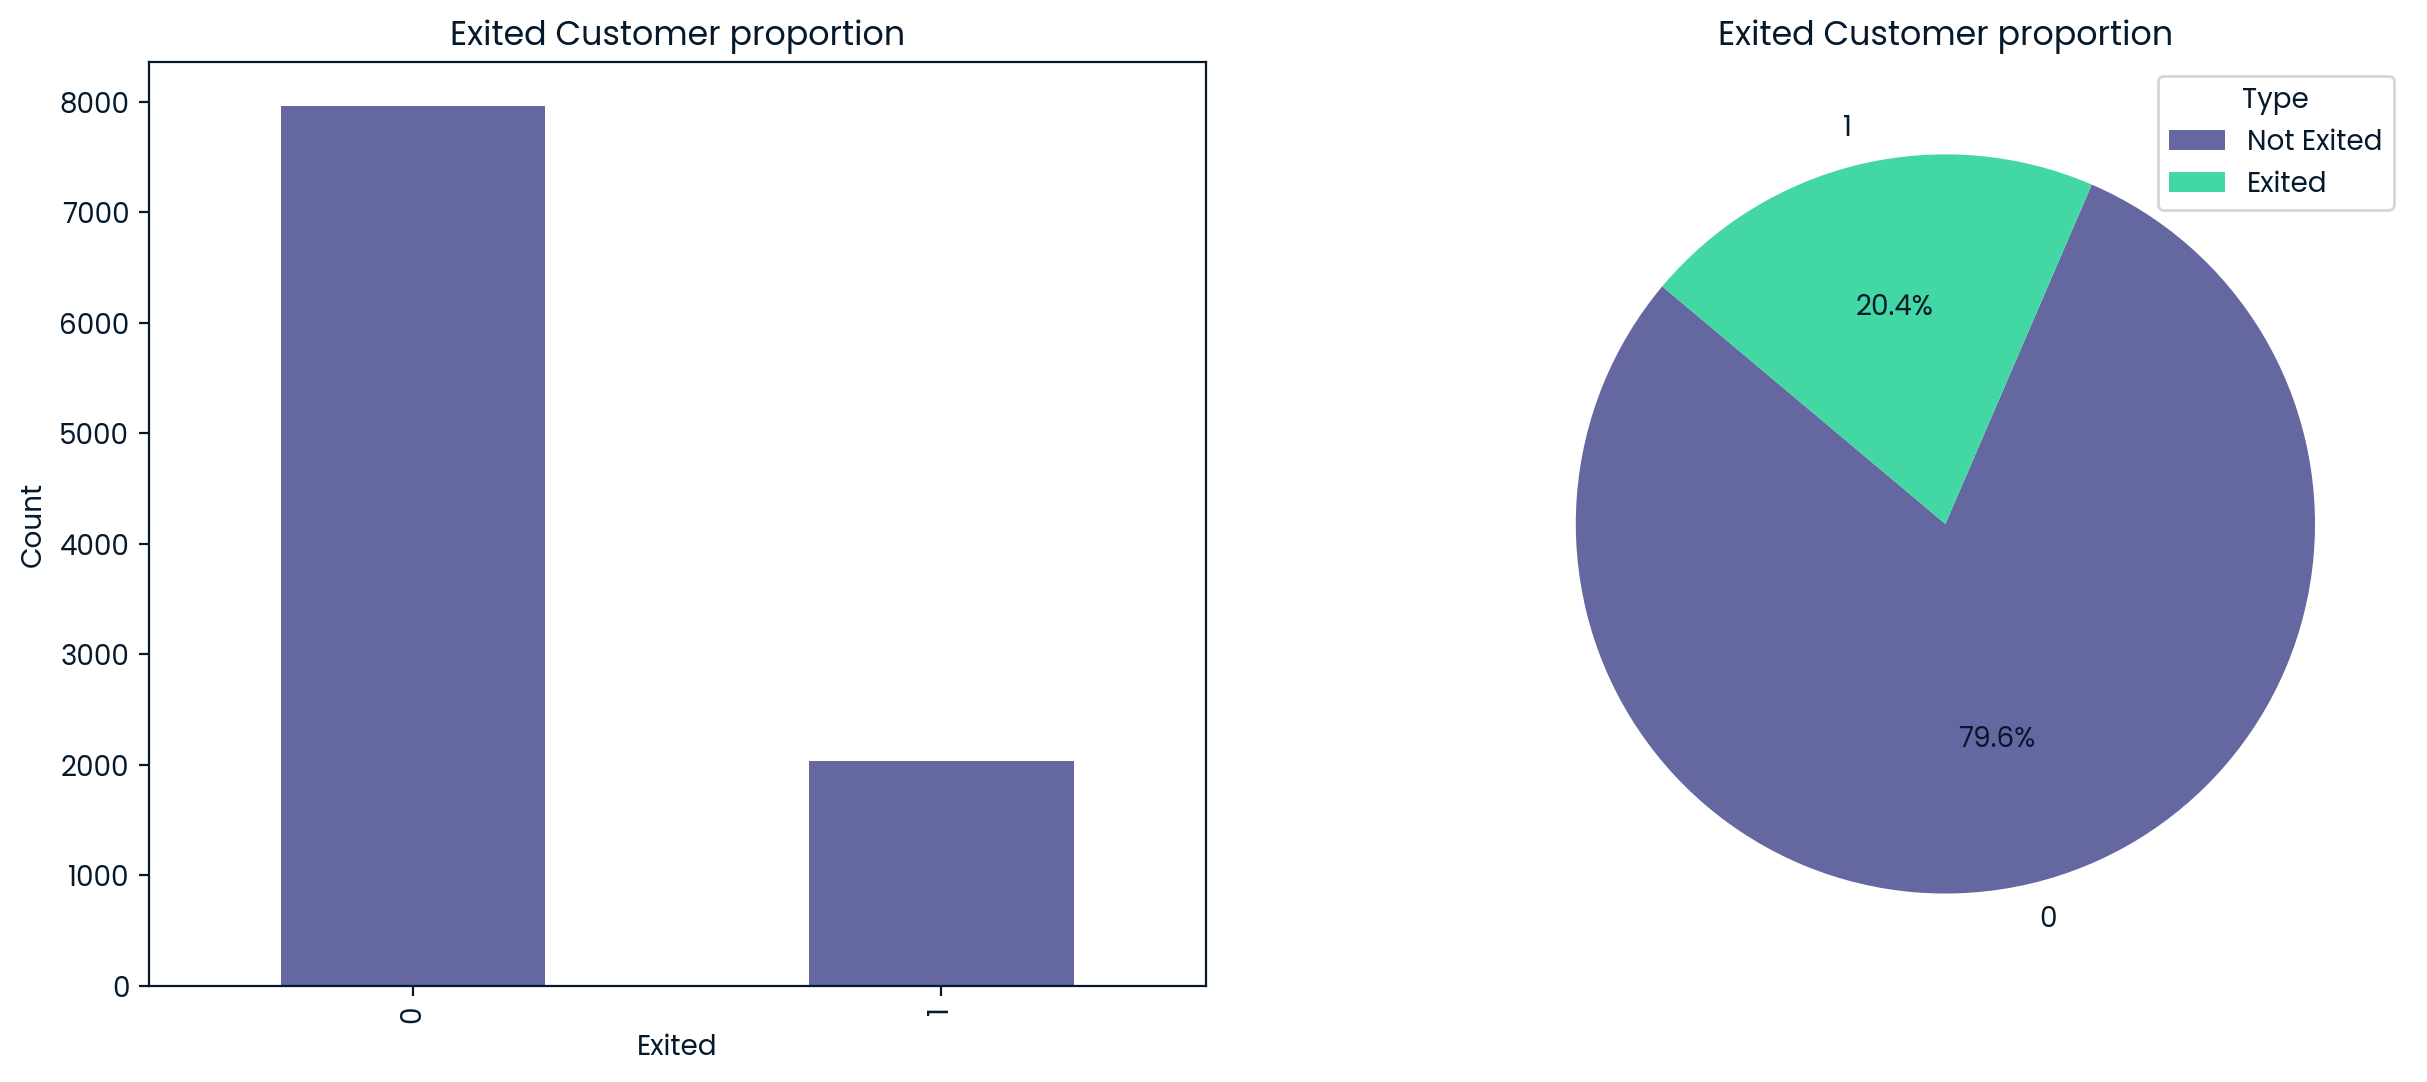

<Figure size 1500x1000 with 0 Axes>

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

exited_count.plot(kind='bar', ax=ax1)
ax1.set_title("Exited Customer proportion")
ax1.set_xlabel("Exited")
ax1.set_ylabel("Count")

# Plot the pie chart
ax2 = plt.pie(exited_count, labels=exited_count.index, autopct='%1.1f%%', startangle=140)
plt.title("Exited Customer proportion")
plt.legend(title='Type', labels=['Not Exited', 'Exited']);
plt.figure(figsize=(15,10))

There is an **imbalance** in the number of instances in the two classes. This will later inform the need and approach of sampling _(SMOTE)_ which I will employ later on.

## Exploratory Data Analysis (EDA)


The dataset is small, we can not easily get to know it and decide how to tackle some interesting questions. From the introductory code above we know:
* `GEOGRAPHY` is categorical variable taking 14 values
* `GENDER` is binary 
* There are many are numerical continuous variables  

First of all, let's ensure there are no nulls:

In [7]:
df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There are no missing values in the data

In [8]:
df.describe().T

count          mean  ...           75%          max
CustomerId       10000.0  1.569094e+07  ...  1.575323e+07  15815690.00
CreditScore      10000.0  6.505288e+02  ...  7.180000e+02       850.00
Age              10000.0  3.892180e+01  ...  4.400000e+01        92.00
Tenure           10000.0  5.012800e+00  ...  7.000000e+00        10.00
Balance          10000.0  7.648589e+04  ...  1.276442e+05    250898.09
NumOfProducts    10000.0  1.530200e+00  ...  2.000000e+00         4.00
HasCrCard        10000.0  7.055000e-01  ...  1.000000e+00         1.00
IsActiveMember   10000.0  5.151000e-01  ...  1.000000e+00         1.00
EstimatedSalary  10000.0  1.000902e+05  ...  1.493882e+05    199992.48
Exited           10000.0  2.037000e-01  ...  0.000000e+00         1.00

[10 rows x 8 columns]

In [9]:
df.describe(exclude='number').T

count unique     top  freq
Surname    10000   2932   Smith    32
Geography  10000      3  France  5014
Gender     10000      2    Male  5457

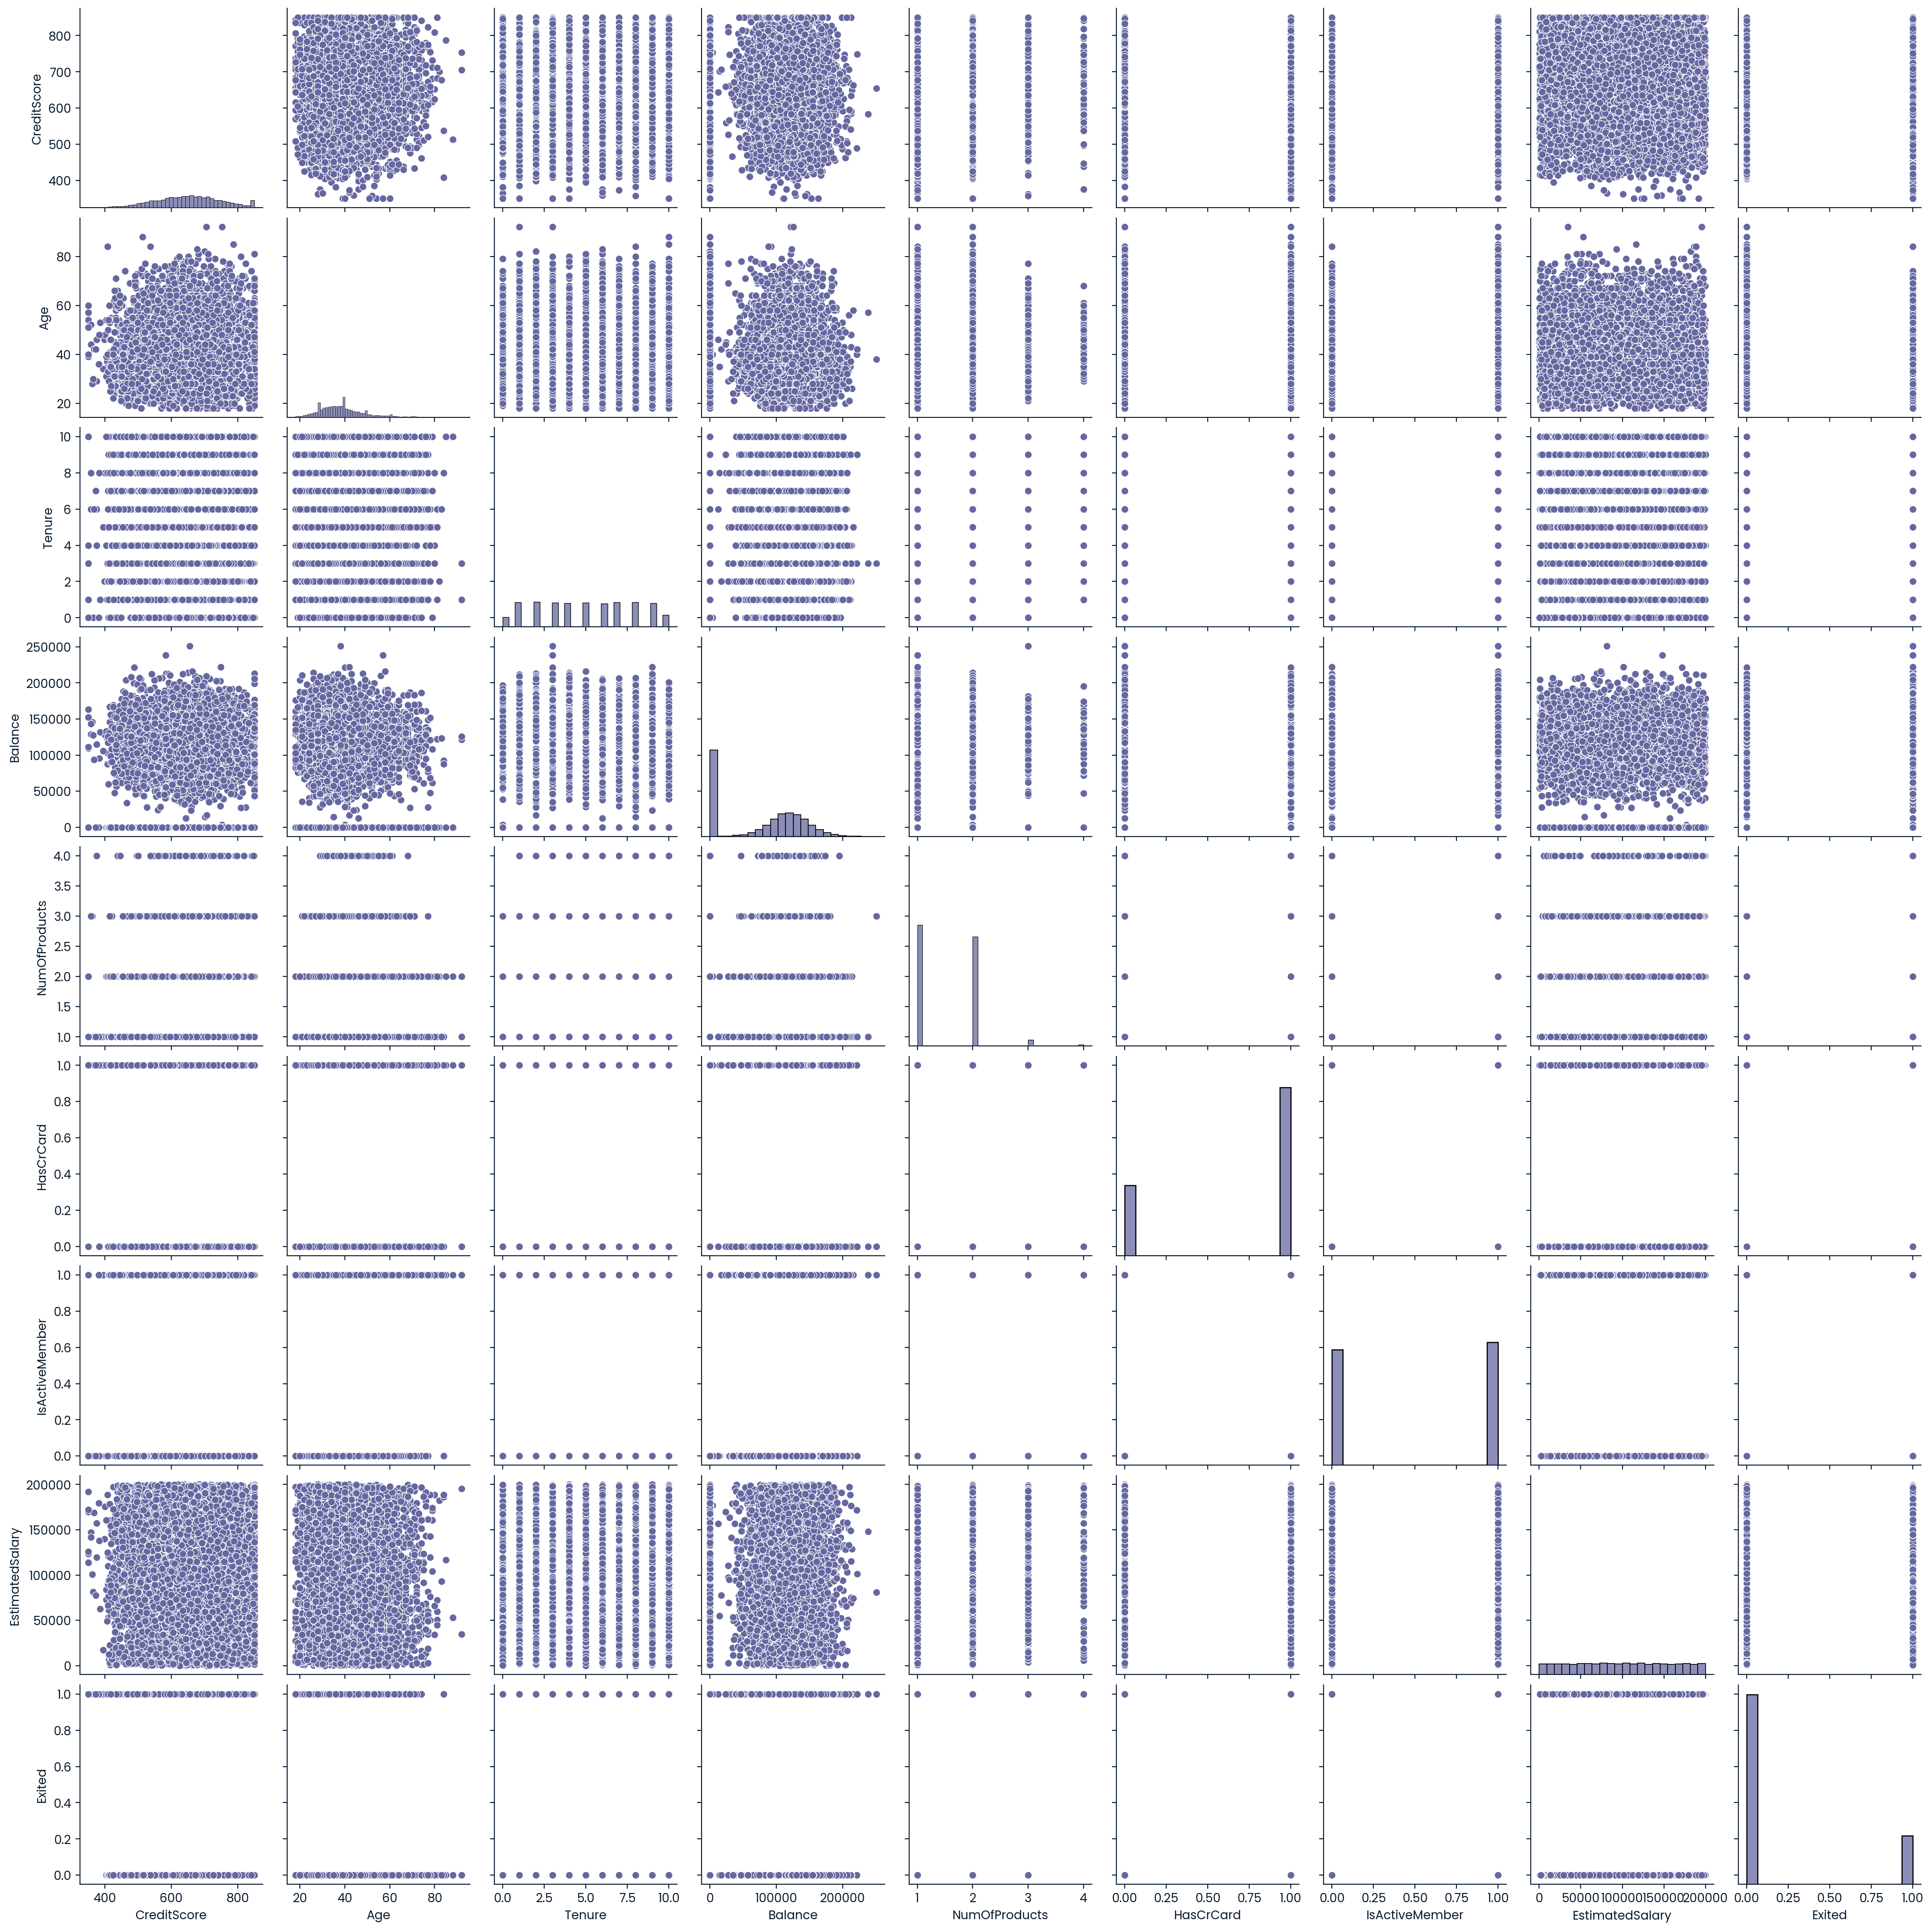

In [10]:
# Selecting relevant columns for visualization
columns_of_interest = df.drop(['Surname', 'Geography', 'CustomerId'], axis=1).columns

df_subset = pd.DataFrame(df[columns_of_interest])
sns.pairplot(df_subset)

<Figure size 1500x1000 with 0 Axes>

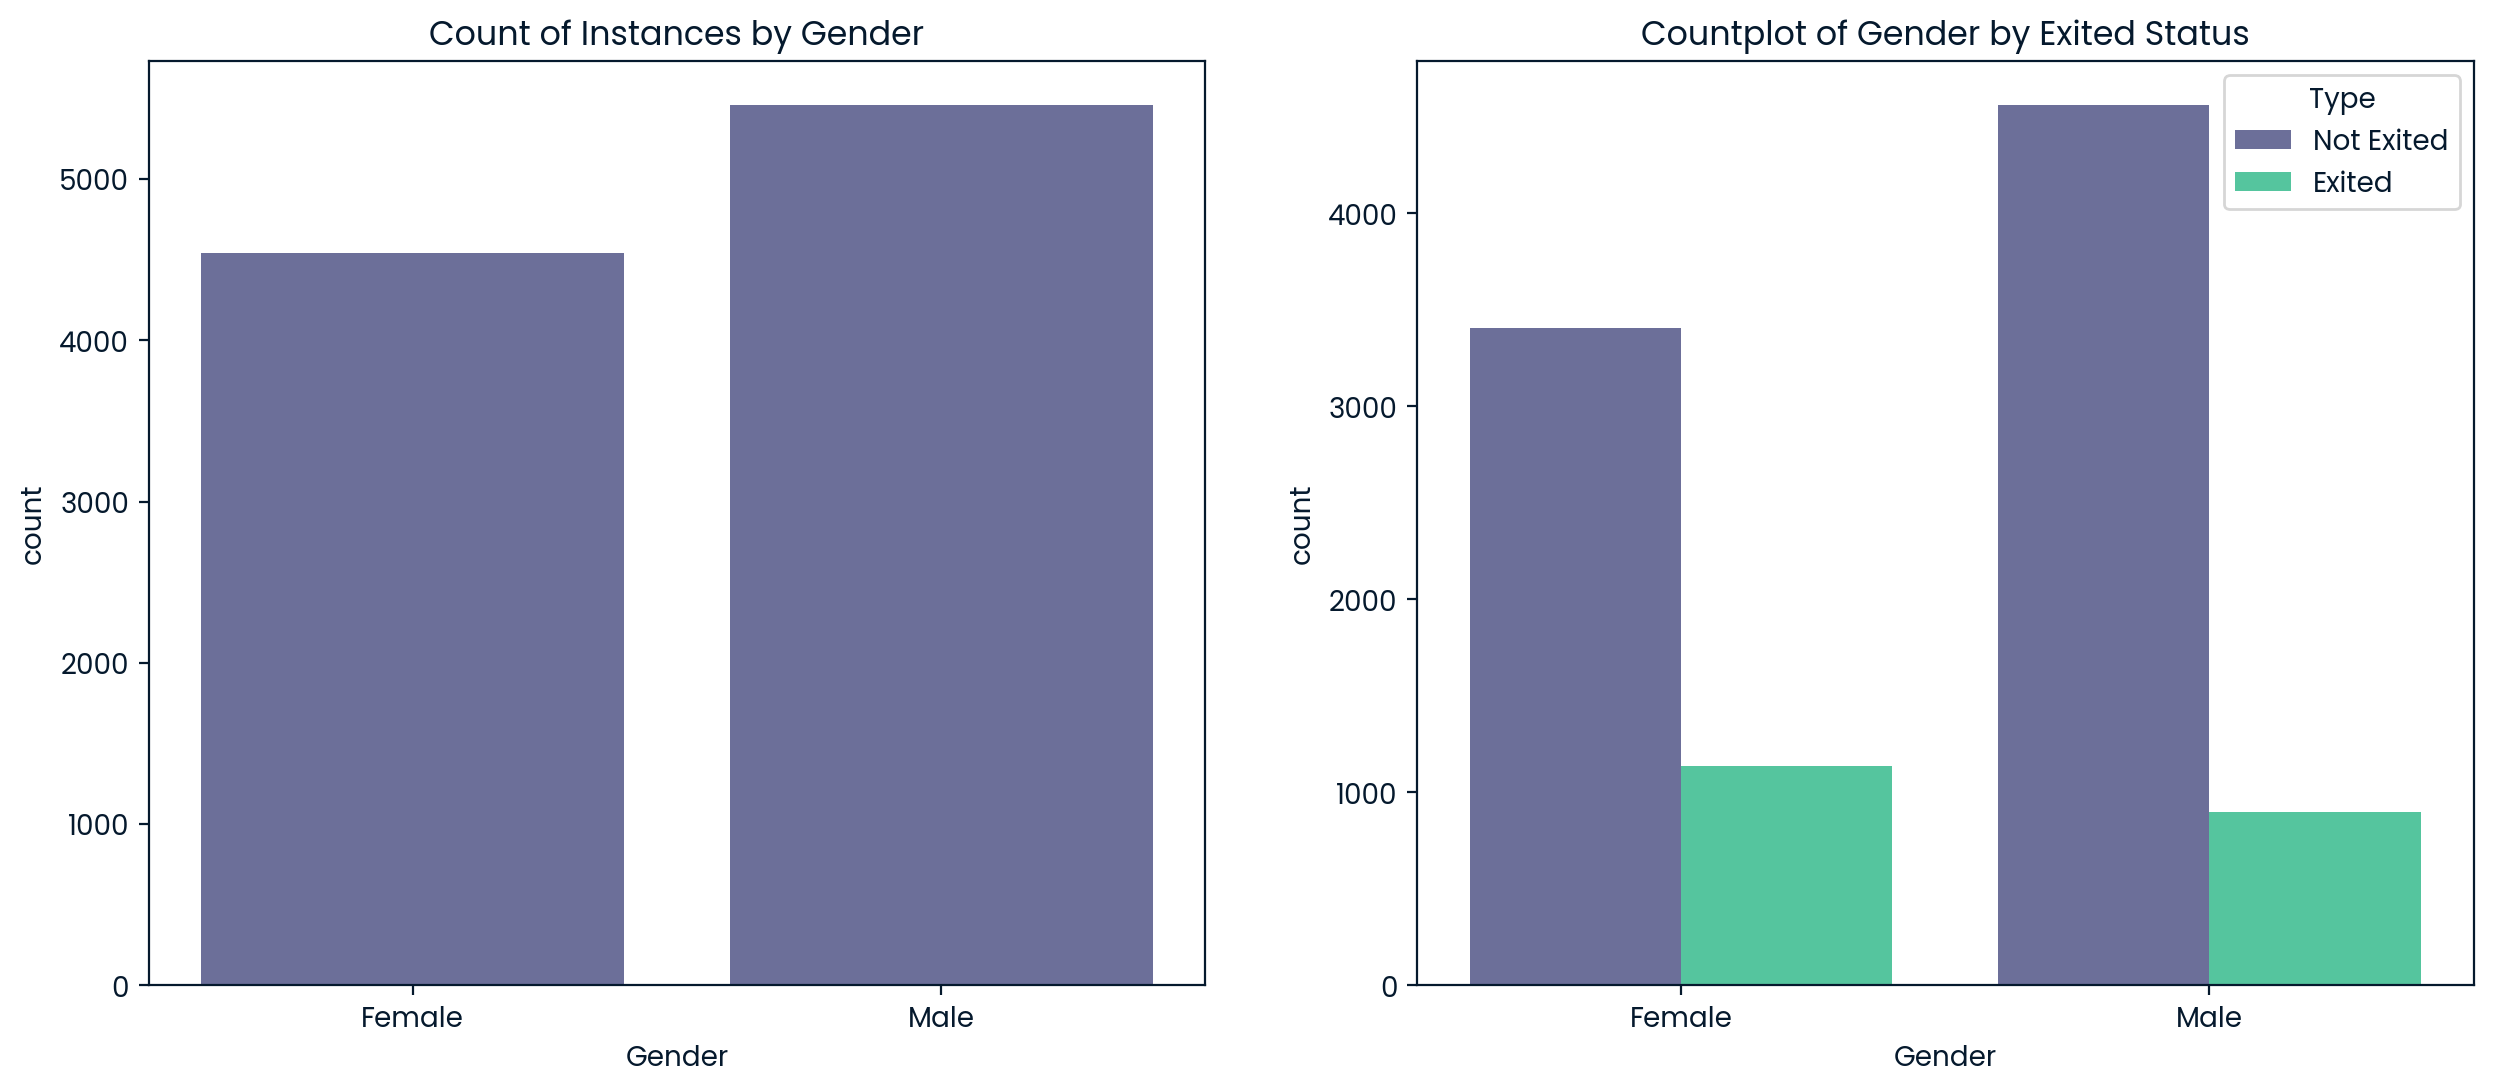

<Figure size 1500x1000 with 0 Axes>

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(data=df, x='Gender', ax=ax1)
ax1.set_title('Count of Instances by Gender')

sns.countplot(data=df, x='Gender', hue='Exited', ax=ax2)
ax2.set_title('Countplot of Gender by Exited Status')
ax2.legend(title='Type', labels=['Not Exited', 'Exited'])

plt.legend(title='Type', labels=['Not Exited', 'Exited']);
plt.figure(figsize=(15,10))

The figure above shows that male customers are more than female customers in the dataset. Also, among both genders, the number of exited customers is relatively the same in percentage.

<Figure size 1500x1000 with 0 Axes>

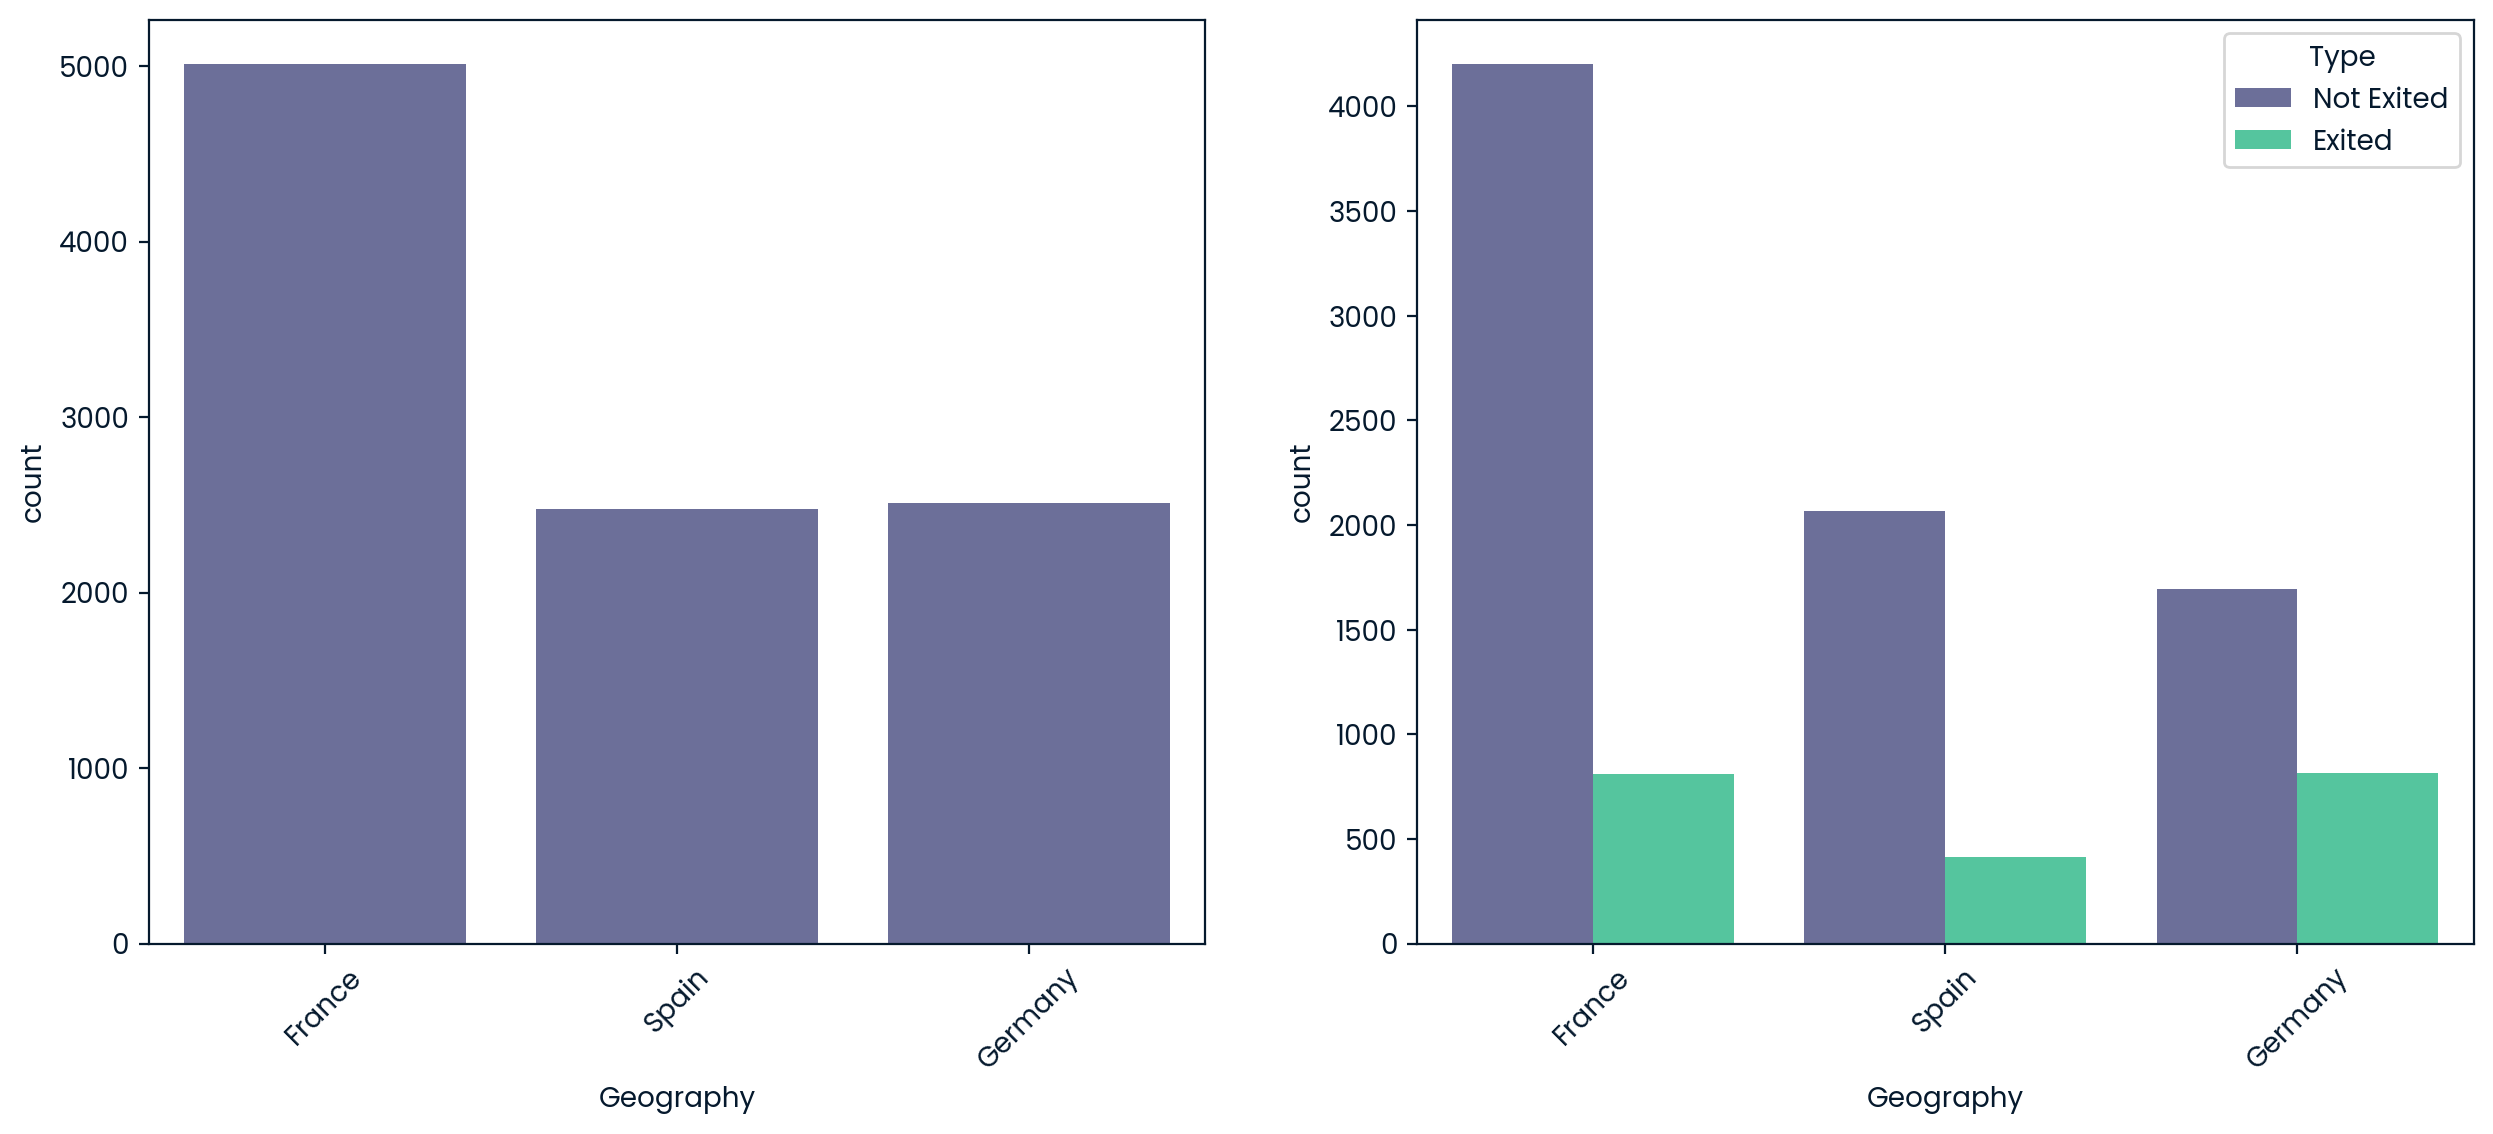

<Figure size 1500x1000 with 0 Axes>

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(data=df, x='Geography', ax=ax1)
sns.countplot(data=df, x='Geography', hue='Exited', ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.legend(title='Type', labels=['Not Exited', 'Exited']);
plt.figure(figsize=(15,10))

There are twice as much bank customers from France than Spain and Germany each. About half of the customers from Germany has exited the bank while France has lowest percentage customer exit followed by Spain

<Figure size 1500x1000 with 0 Axes>

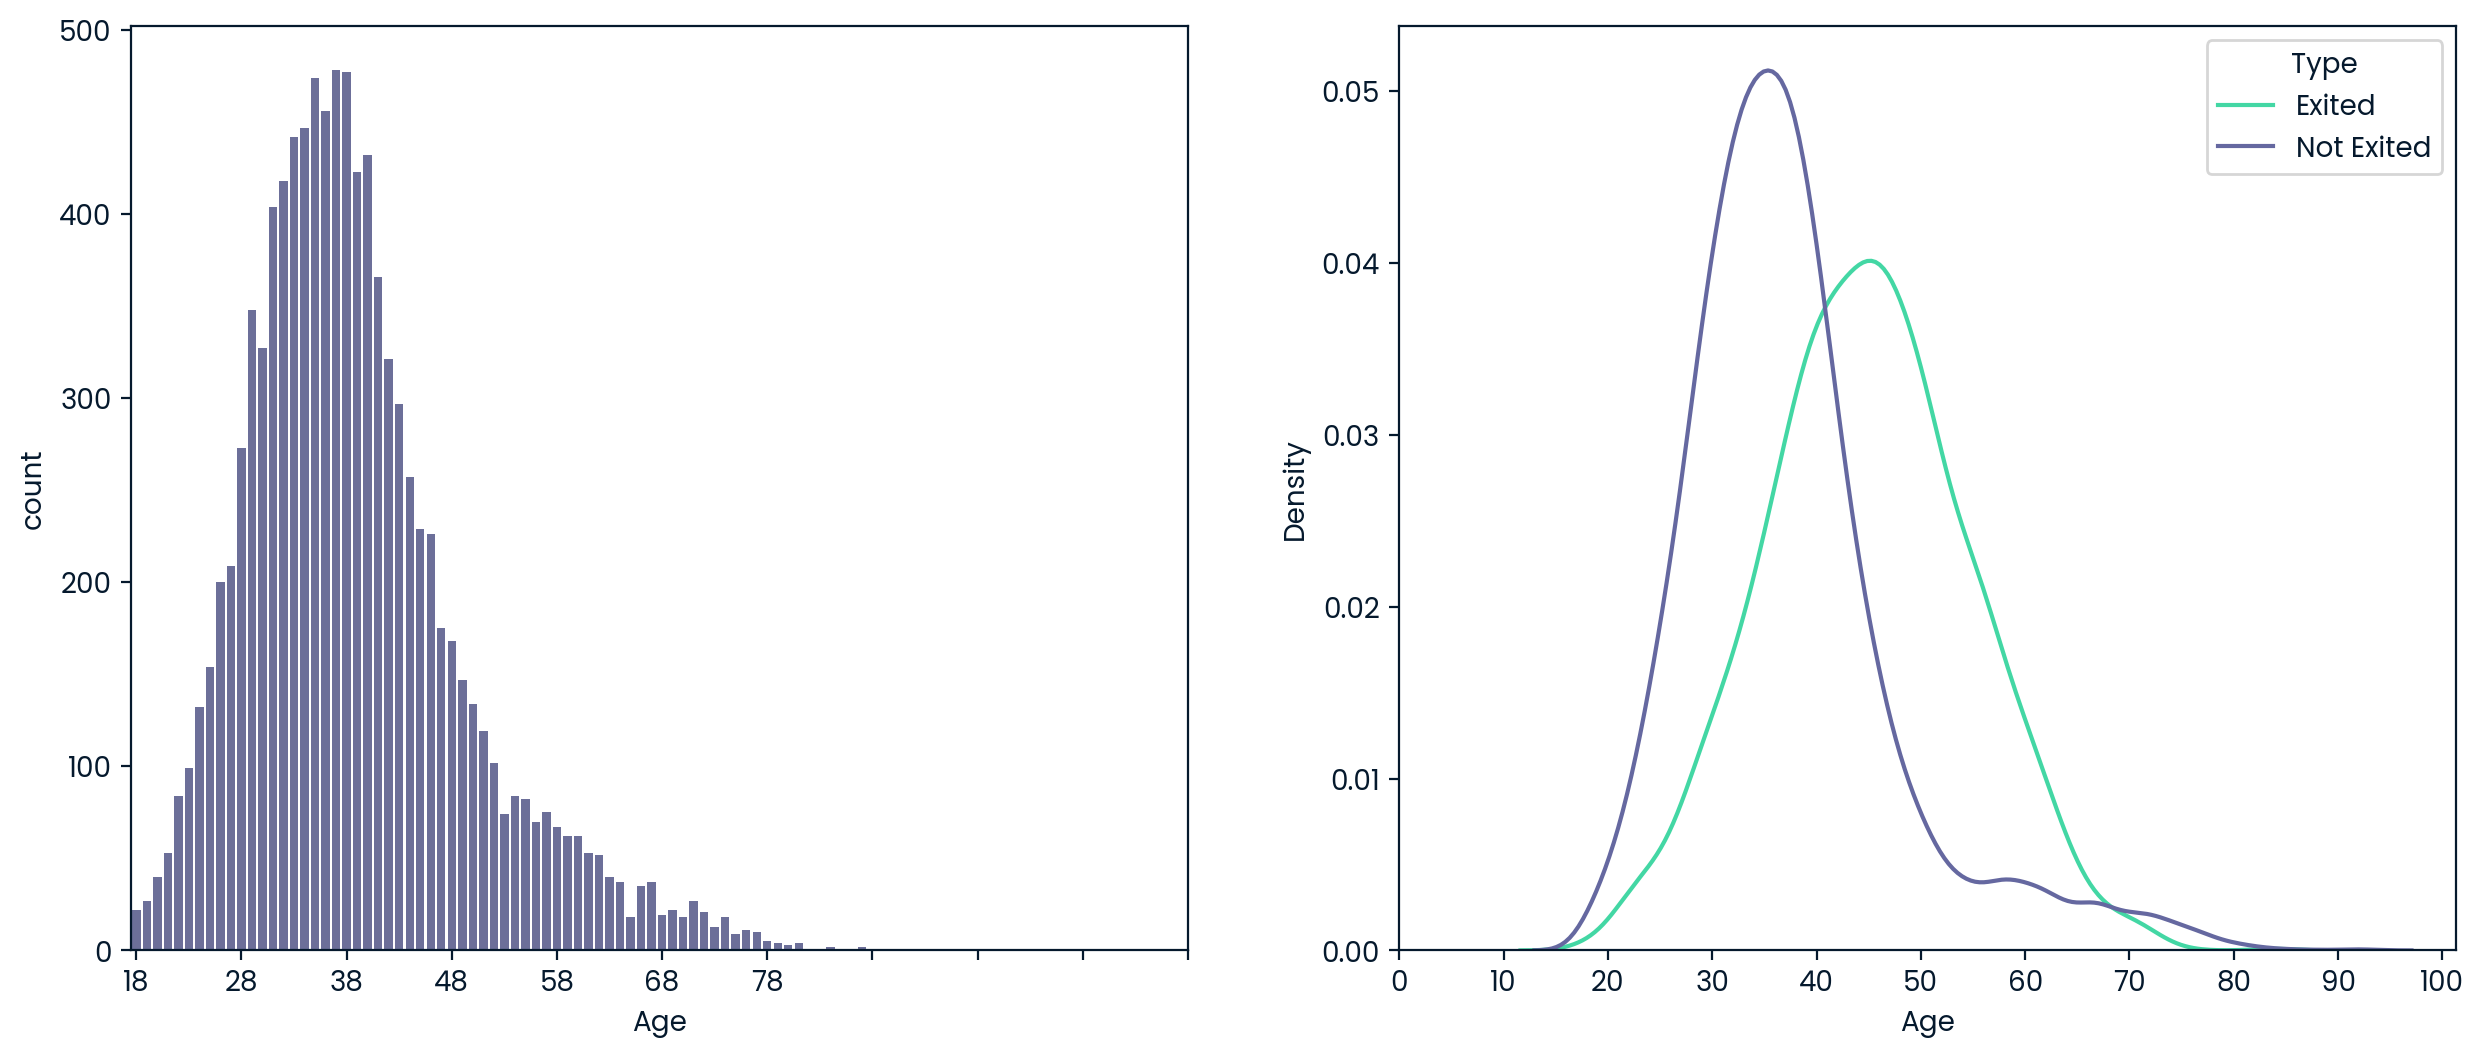

<Figure size 1500x1000 with 0 Axes>

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_subset, x='Age', ax=ax1)
ax1.set_xticks(np.arange(0, 110, 10))
ax2.set_xticks(np.arange(0, 110, 10))

sns.kdeplot(data=df_subset, x='Age', hue='Exited', common_norm=False, ax=ax2)
plt.xticks(np.arange(0, 110, 10))
plt.legend(title='Type', labels=['Exited', 'Not Exited']);
plt.figure(figsize=(15,10))

It shows that bank has a lot of customers within the 35-45 age bracket and most of the exited customers are within the age bracket of 40-55

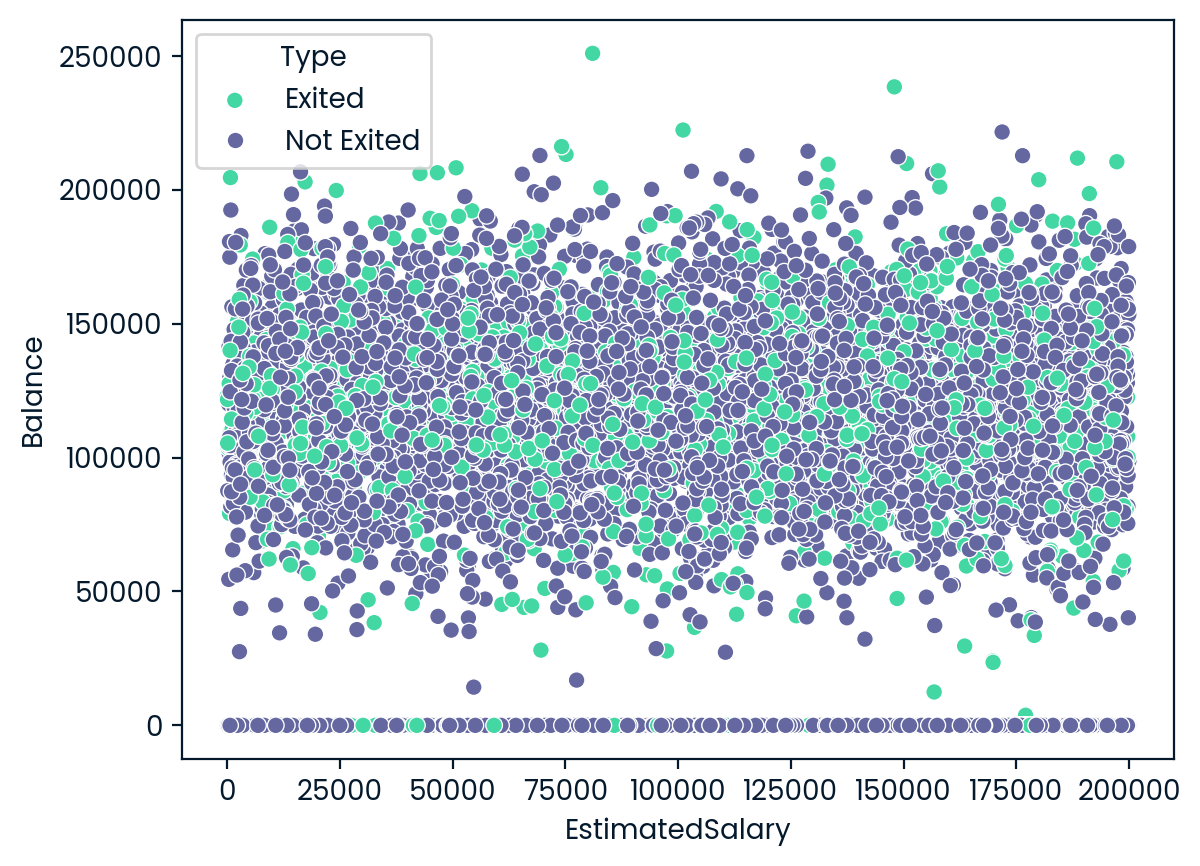

In [14]:
sns.scatterplot(data=df_subset, x='EstimatedSalary', y='Balance', hue='Exited')
plt.legend(title='Type', labels=['Exited', 'Not Exited']);

Most customers have a balance of 50,000-200,000 in the bank account and that the balance doesn't influence the exit status

## Data Preprocessing

In [15]:
# Feature engineering to remove redundant features
label_encoder = LabelEncoder()
df_subset['Gender'] = label_encoder.fit_transform(df_subset['Gender'])
df_subset.head()

CreditScore  Gender  Age  ...  IsActiveMember  EstimatedSalary  Exited
RowNumber                            ...                                         
1                  619       0   42  ...               1        101348.88       1
2                  608       0   41  ...               1        112542.58       0
3                  502       0   42  ...               0        113931.57       1
4                  699       0   39  ...               0         93826.63       0
5                  850       0   43  ...               1         79084.10       0

[5 rows x 10 columns]

Here, I performed some feature engineering to encoded categorical features in the dataset

In [16]:
df_subset.shape

(10000, 10)

I have reduced the number of features from 13 to 10

In [17]:
# Perform preprocessing
df_subset.dtypes

CreditScore          int64
Gender               int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

I have succesfully engineered all the features in the dataset to numeric values by encoding and feature selection 

## Predict if a customer will exit or not

In [18]:
X = df_subset.drop(['Exited'], axis=1)
y = df_subset['Exited']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [19]:
# Train model with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(y_train_resampled.value_counts())

0    5574
1    5574
Name: Exited, dtype: int64


The imbalance in the target variable `Exited` can result in poor generalization performance, therefore, I had too smote the dataset i.e increasing the instances of the smaller class

In [20]:
# Instantiate a StandardScaler
scaler = StandardScaler()

#### Setting up the pipelines
Pipelines will be set up for each model I try: Random Forest and Gradient Boosting are good models for binary classification, Logistic Regression is included for benchmarking too

In [21]:
#set up pipelines with preprocessing & estimators
pipelines = {
    'lr': make_pipeline(scaler, LogisticRegression(random_state=42)),
    'rf': make_pipeline(scaler, RandomForestClassifier(random_state=42)),
    'gb': make_pipeline(scaler, GradientBoostingClassifier(random_state=42)),
}

#### Evaluating the simple models
The *roc-curve* shows how well the model performs: The more area under the curve, the better the model. We can plot the curve for each of the four models we trained, and show its *accuracy* (ACC) and *Area-Under-the-Curve* (AUC). The visual shows that ***Gradient Boosting* is the best of the naive models**, with the highest AUC and ACC.

In [22]:
def evaluate_model(features, target, model, model_name='Model', title=None, normalize_matrix=None):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    if title is not None:
        f.suptitle(title, fontsize=16)
    
    preds = model.predict(features)
    y_score = model.predict_proba(features)[:, 1] 
    
    accuracy = accuracy_score(target, preds)
    precision = precision_score(target, preds)
    recall = recall_score(target, preds)
    f1 = f1_score(target, preds)
    auc = roc_auc_score(target, y_score)

    c_matrix = confusion_matrix(target, preds, normalize=normalize_matrix)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=model.classes_)
    
    cm_display.plot(ax=ax1)
    ax1.grid(False)
    ax1.set_title("{} Confusion matrix".format(model_name))

    fpr, tpr, threshold = roc_curve(target, y_score)
    ax2.plot(fpr, tpr, label=model_name)
    ax2.plot([0, 1], [0, 1], linestyle="--", c="grey", label='Random Guess')
    ax2.set_title("{} ROC Curve".format(model_name))
    
    plt.legend()
    plt.figure(figsize=(15,10))
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None

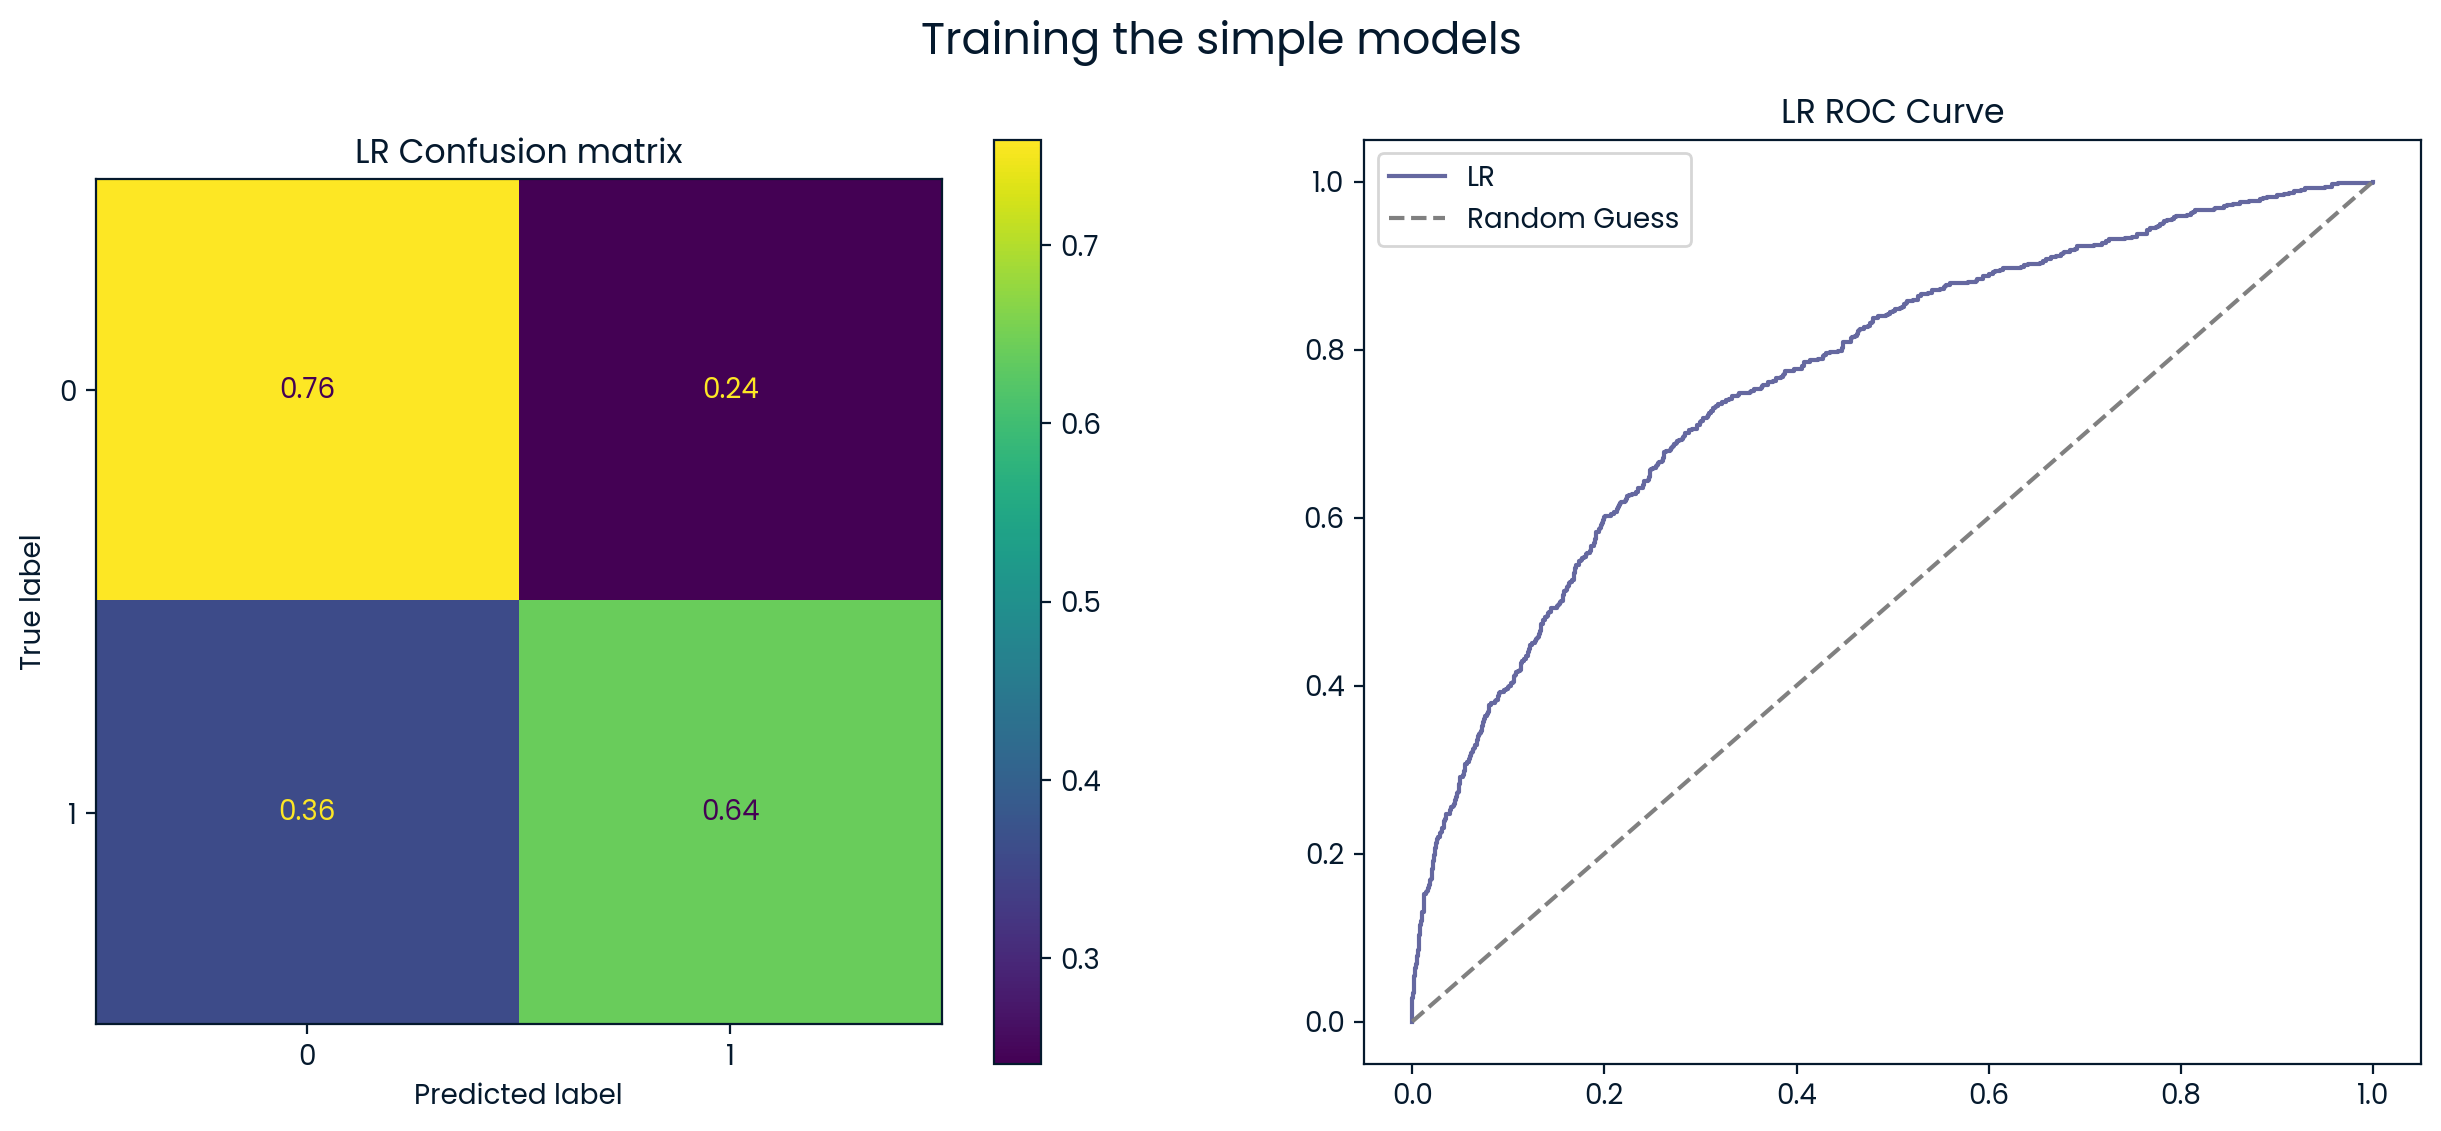

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.74
Precision: 0.4
Recall: 0.64
F1 Score 0.5
AUC: 0.7657553475798445


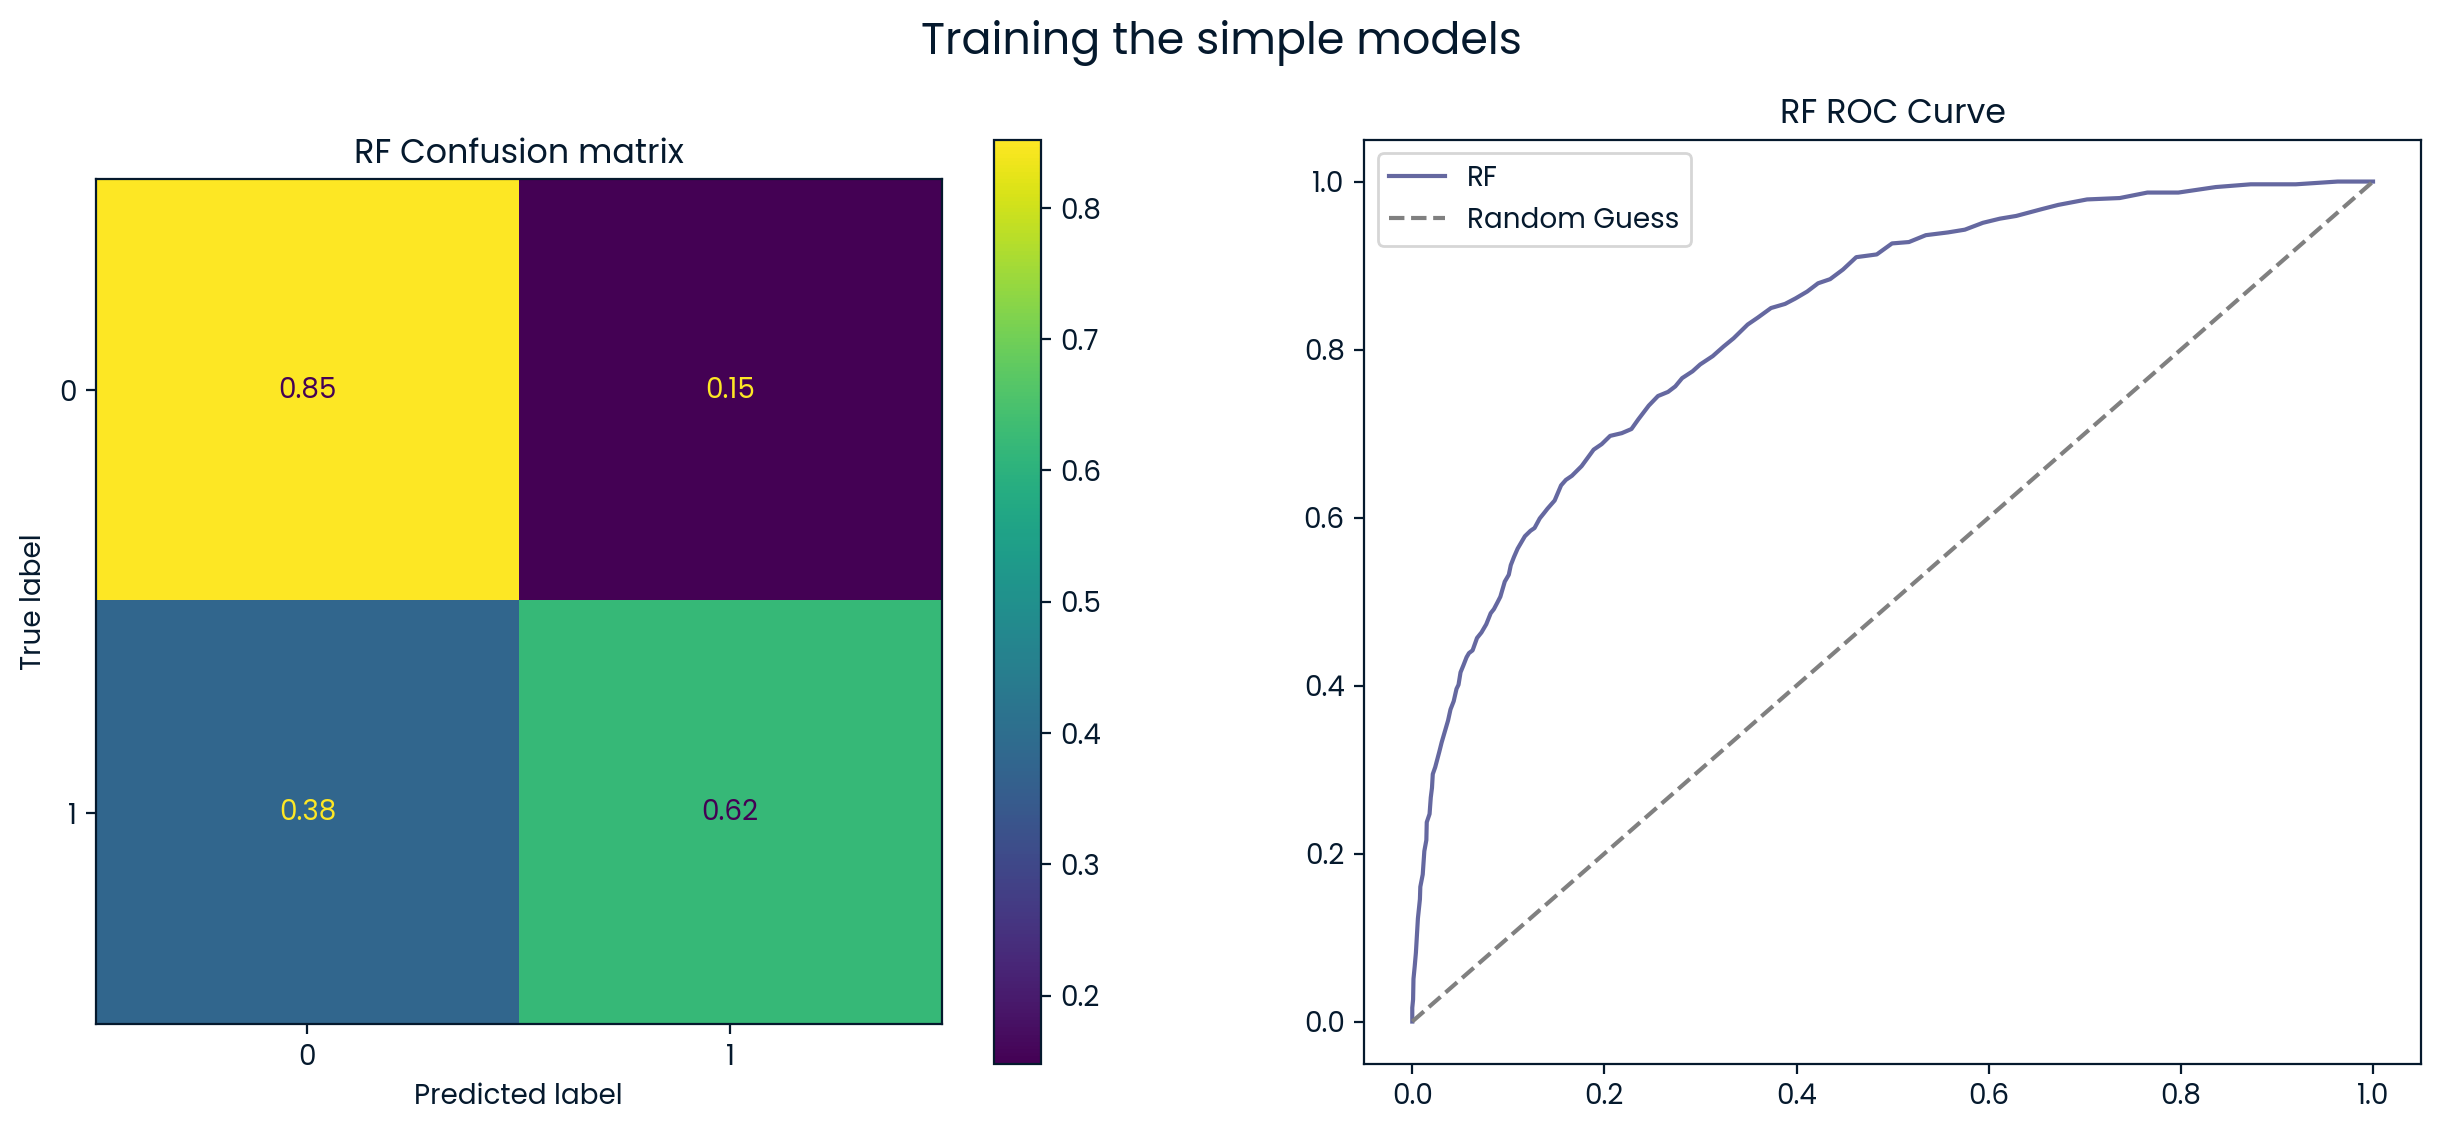

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.8
Precision: 0.52
Recall: 0.62
F1 Score 0.56
AUC: 0.8332318269975797


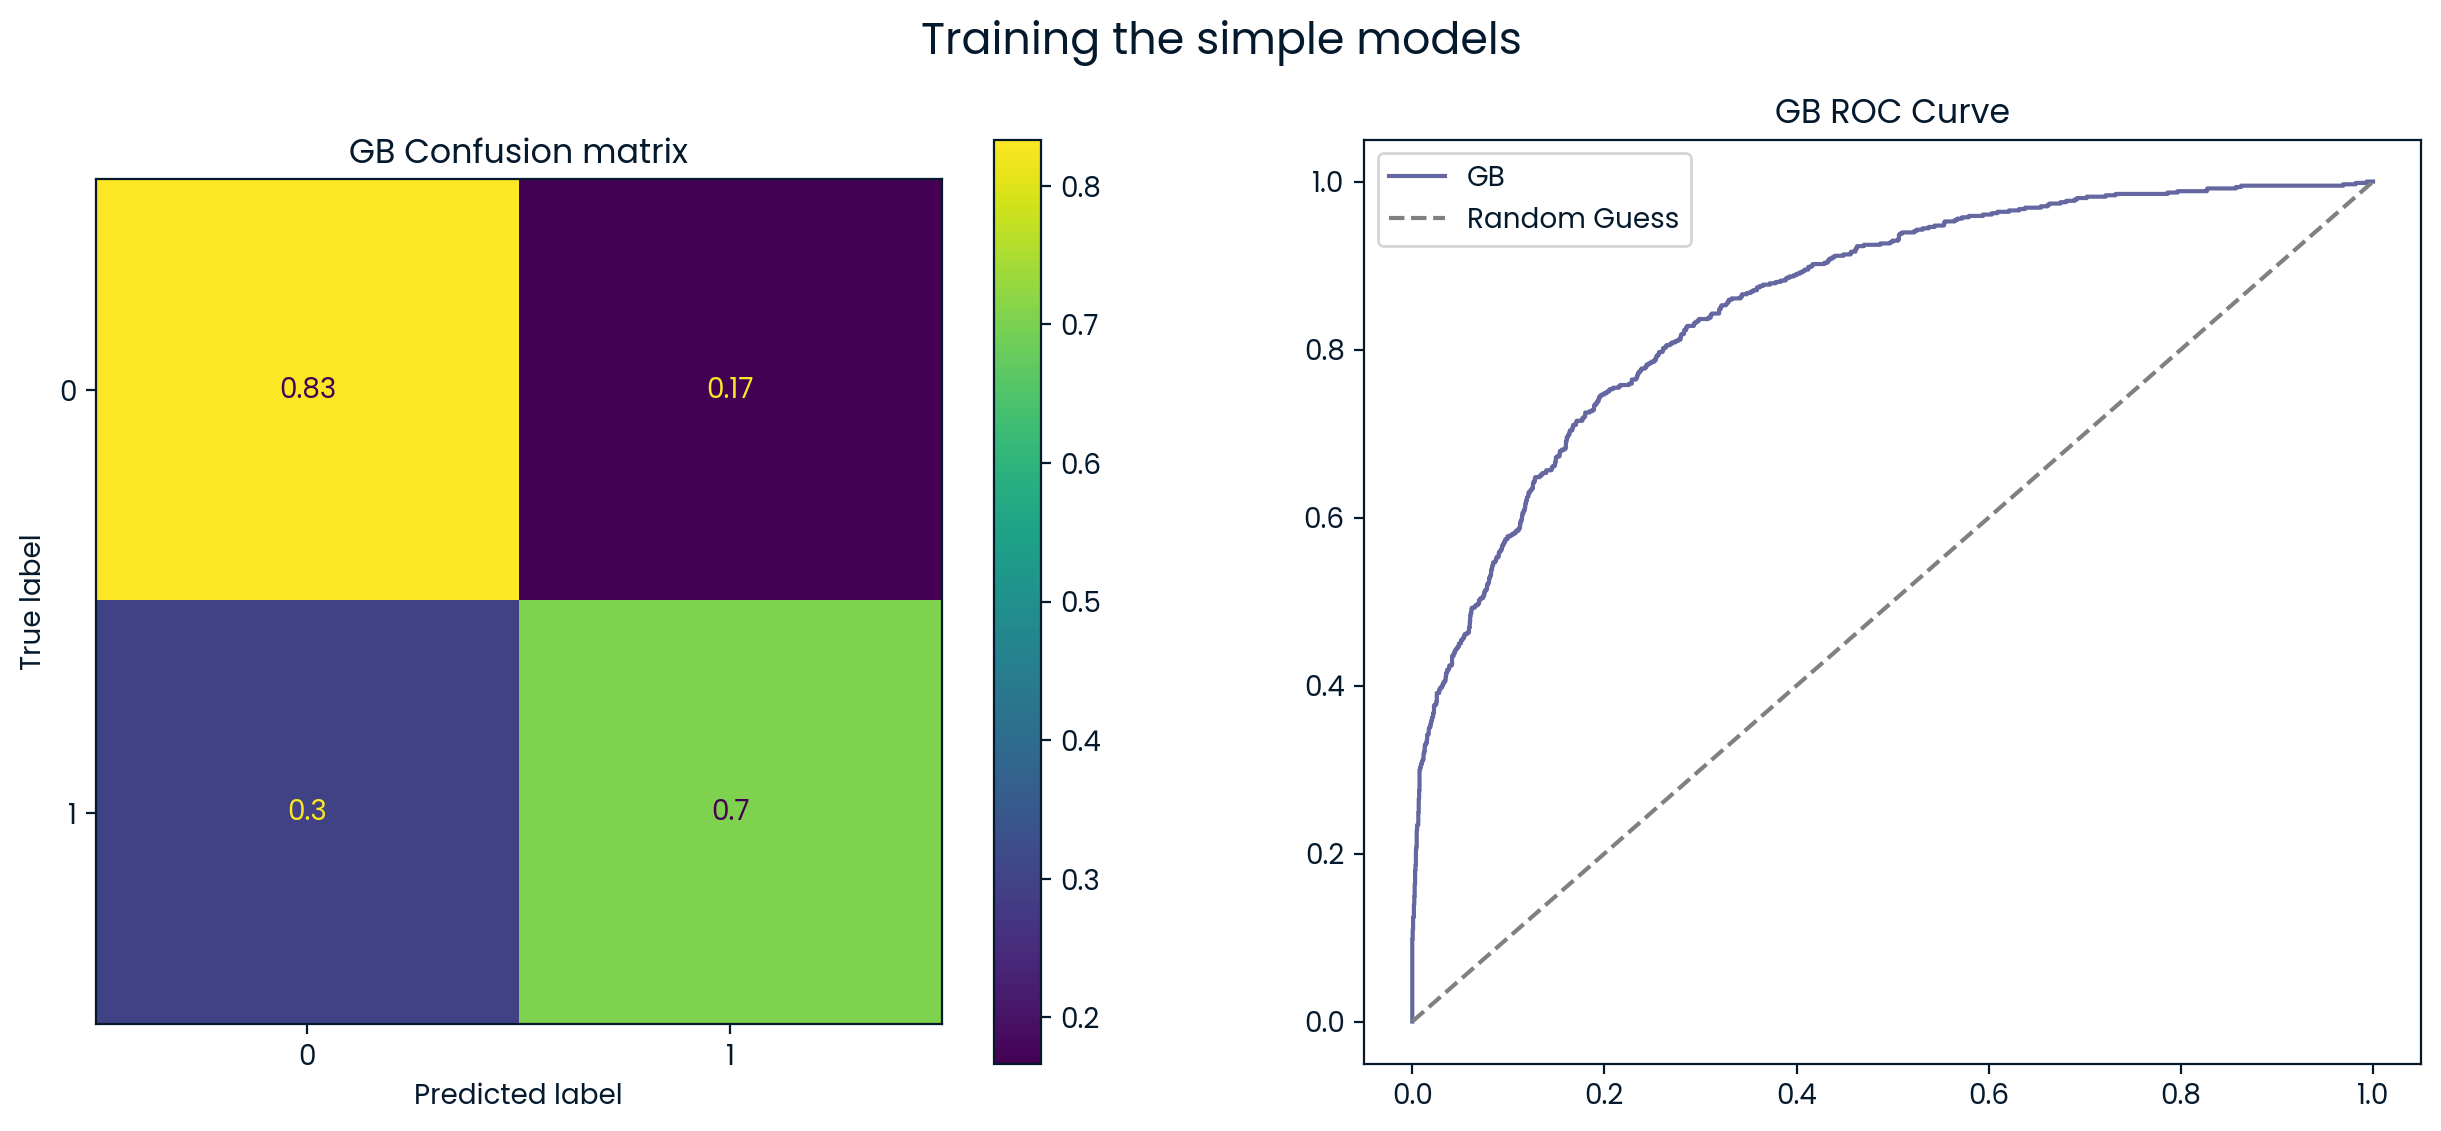

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.81
Precision: 0.52
Recall: 0.7
F1 Score 0.6
AUC: 0.8562923766115701


In [23]:
for name, estimator in pipelines.items():
    estimator.fit(X_train_resampled, y_train_resampled)
    evaluate_model(X_test, y_test, estimator, name.upper(), 'Training the simple models', normalize_matrix='true')


The visual shows that ***Gradient Boosting* is the best of the naive models**, with the highest AUC and ACC.

#### Hyperparameter fine-tuning
Now that we have an idea of the bare minimum of model performance we can perform a Grid Search to fine-tune the hyperparameters of each model. The score we want to maximize is *accuracy*.

In [24]:
#dictionary for hyperparameters (hyperparameter grid) to tune per algorithm:

lr_hyperparameters = {
    'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100],
    'logisticregression__penalty':['l1','l2'],
    'logisticregression__tol':[0.0001, 0.0003, 0.001],
    'logisticregression__max_iter':[100,200,300,400,500],
    'logisticregression__solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'logisticregression__class_weight': ['balanced']
}

rf_hyperparameters = {
    'randomforestclassifier__max_depth' : np.arange(1,4,1),
    'randomforestclassifier__max_leaf_nodes' : np.arange(13,17,1),
    'randomforestclassifier__min_samples_leaf': np.arange(2,5),
    'randomforestclassifier__n_estimators' : [100, 200,300,],
    'randomforestclassifier__min_samples_split' : [4,5,6],    
}

gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [10, 30, 50, 70, 100], 
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
    'gradientboostingclassifier__max_depth': [1, 3, 5],
    'gradientboostingclassifier__min_samples_split': [2, 5, 10],
    'gradientboostingclassifier__min_samples_leaf': [1, 2, 4],
    'gradientboostingclassifier__subsample': [0.8, 0.9, 1.0],
    'gradientboostingclassifier__max_features': [1, 3, 5, 'auto', 'sqrt', 'log2']
}

param_grid = {
    'gb': gb_hyperparameters,
    'lr': lr_hyperparameters,
    'rf': rf_hyperparameters,
}


**Training the fine-tuned models**

In [25]:
fitted_models = {}
for name, estimator in pipelines.items():
    print("fitting model:",name,"...")
    model = RandomizedSearchCV(estimator, 
                         param_distributions=param_grid[name], 
                         cv=3, 
                         scoring='accuracy',
                         verbose=1, 
                         n_jobs=-1,
                       n_iter=1000, 
                       random_state=42
                        )
    model.fit(X_train_resampled, y_train_resampled)
    fitted_models[name] = model
    print('---')
          

fitting model: lr ...
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
---
fitting model: rf ...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
---
fitting model: gb ...
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
---


**Evaluating the fine-tuned models**

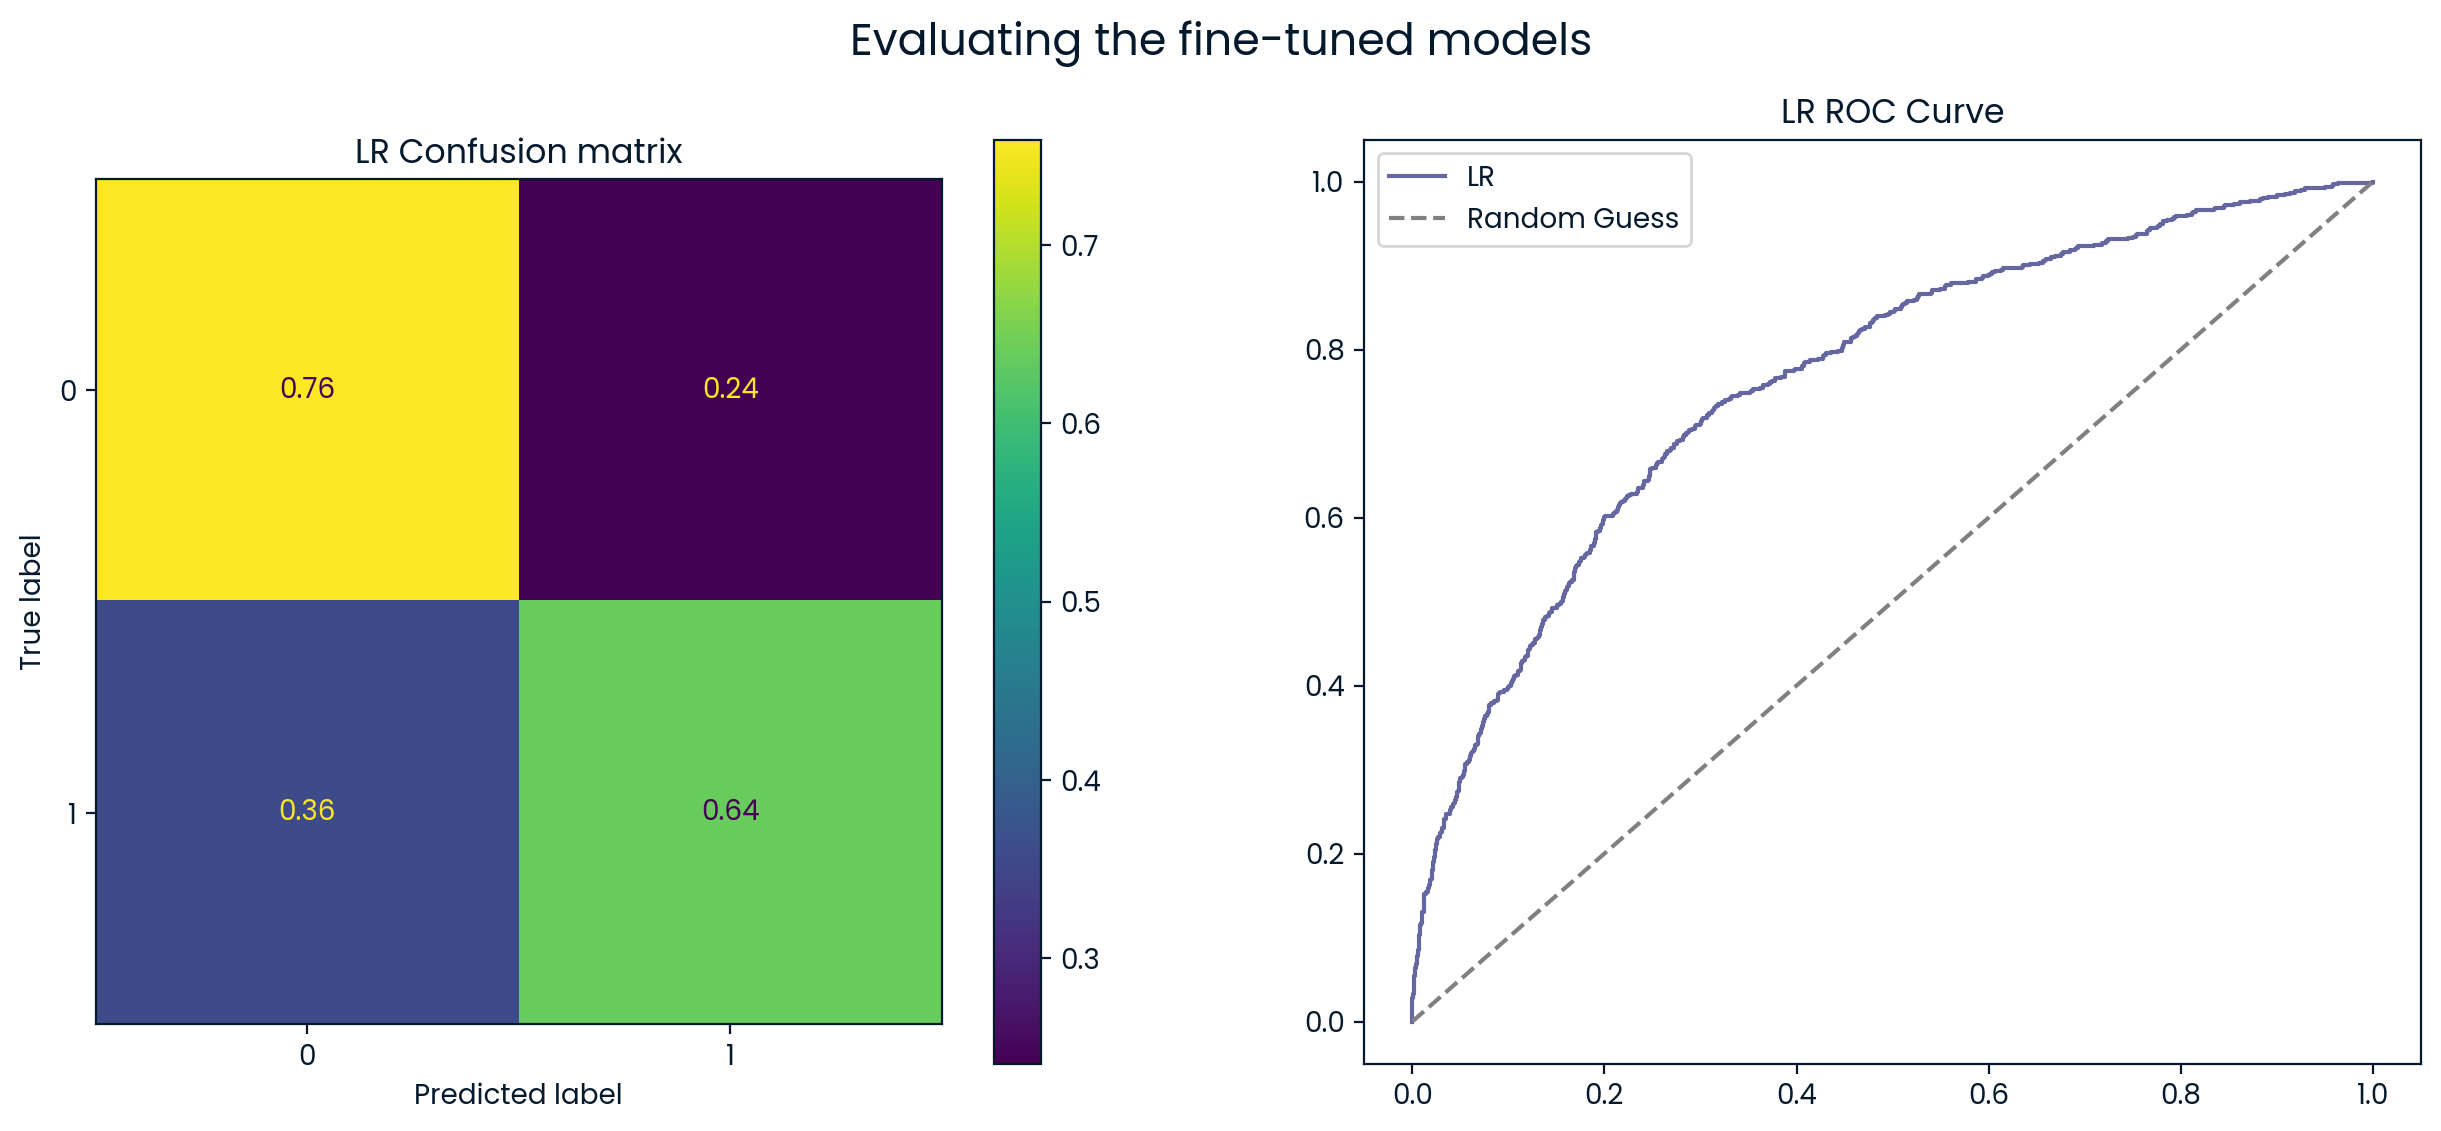

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.73
Precision: 0.4
Recall: 0.64
F1 Score 0.49
AUC: 0.7656971155987036


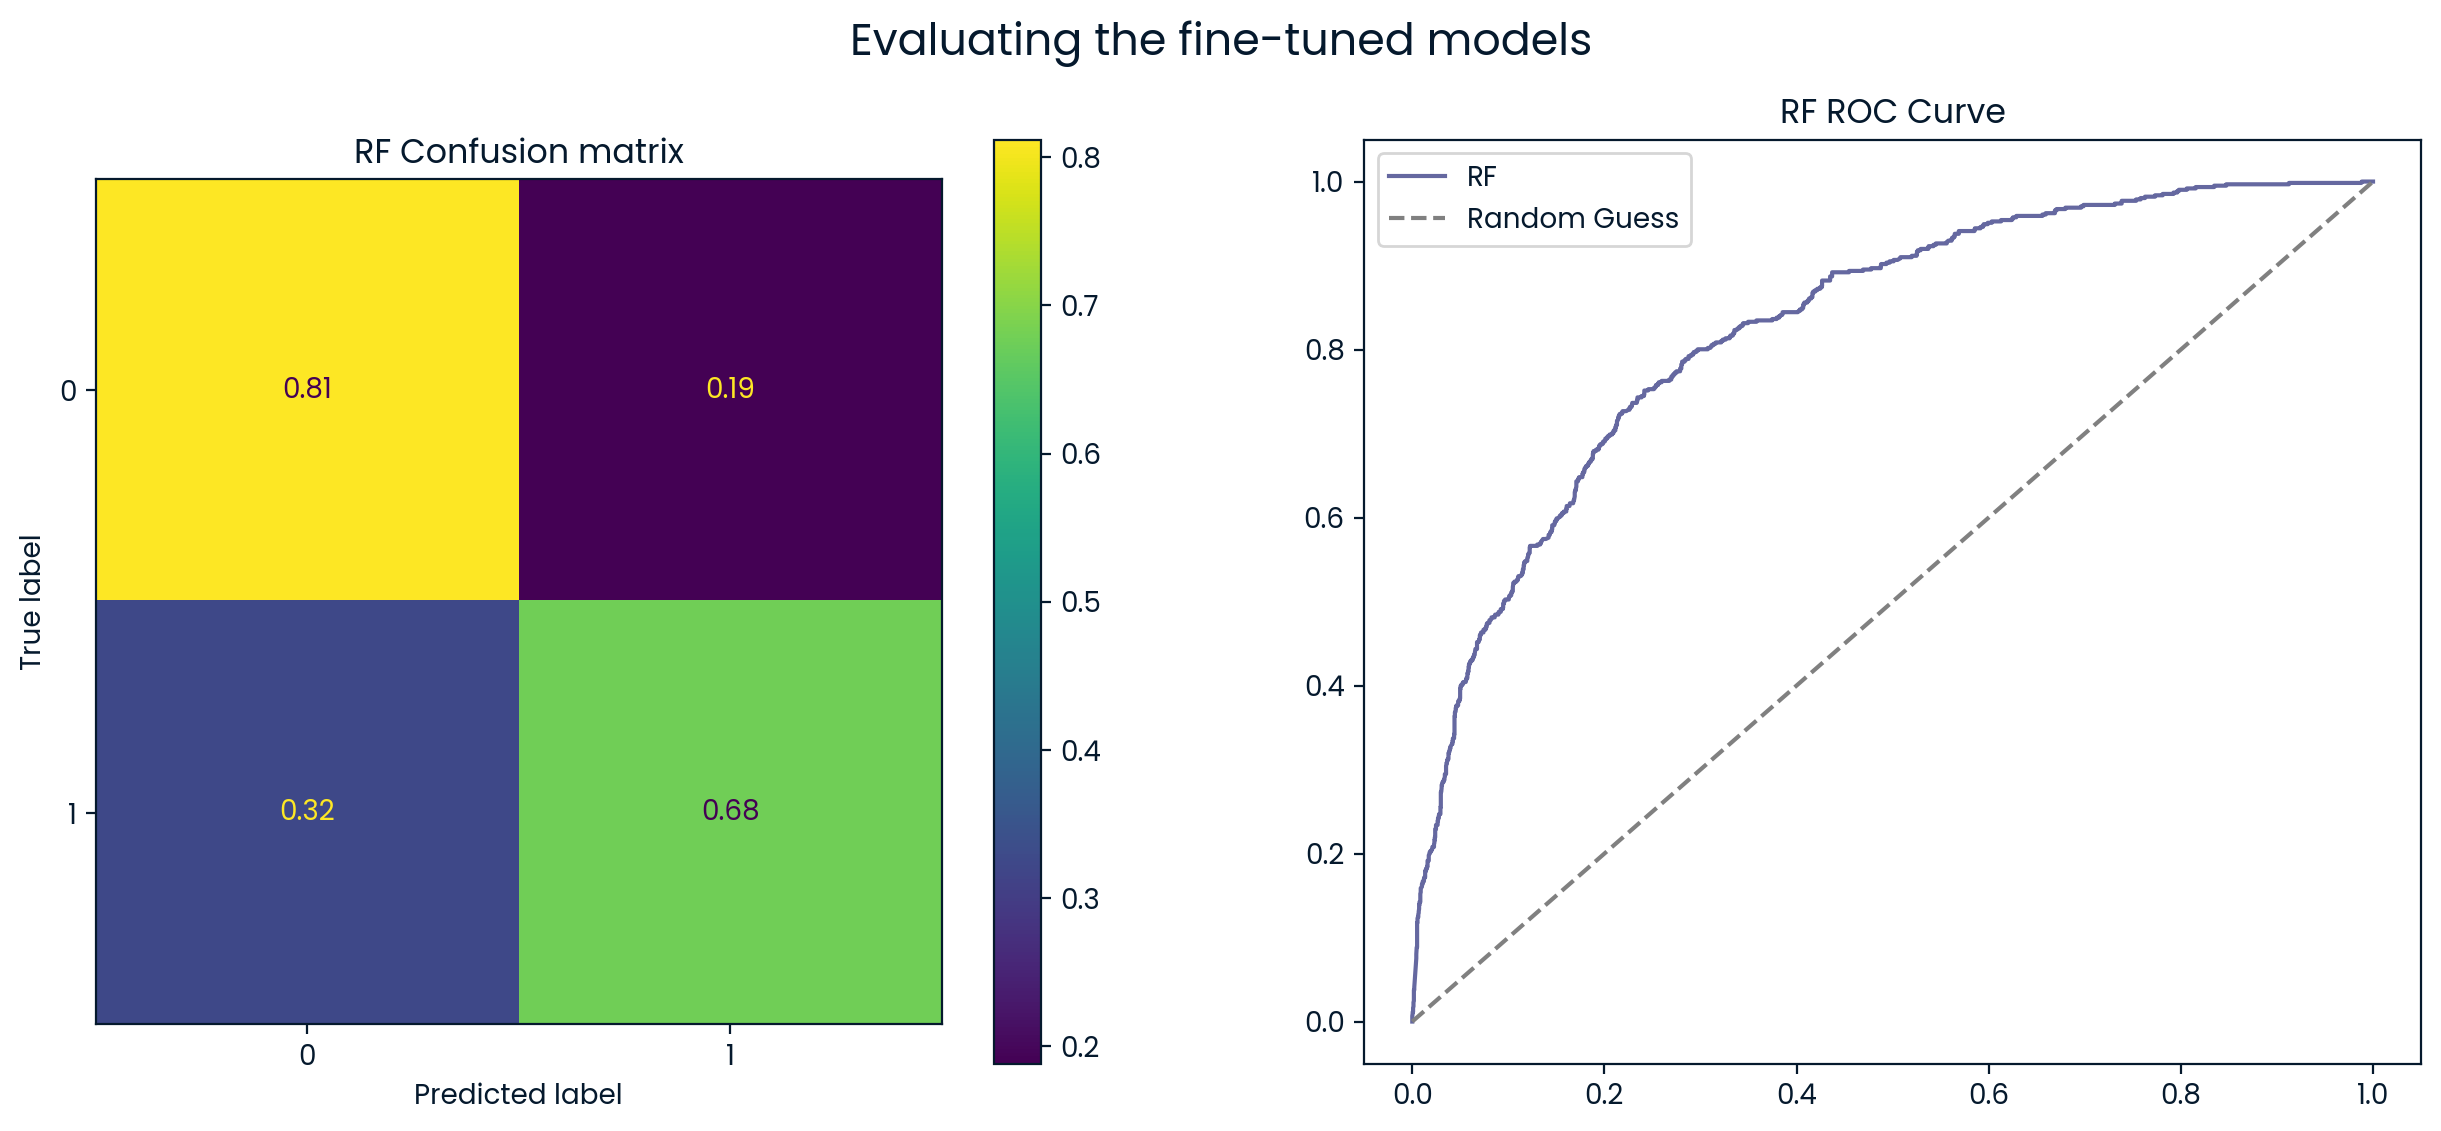

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.78
Precision: 0.48
Recall: 0.68
F1 Score 0.56
AUC: 0.826776983158626


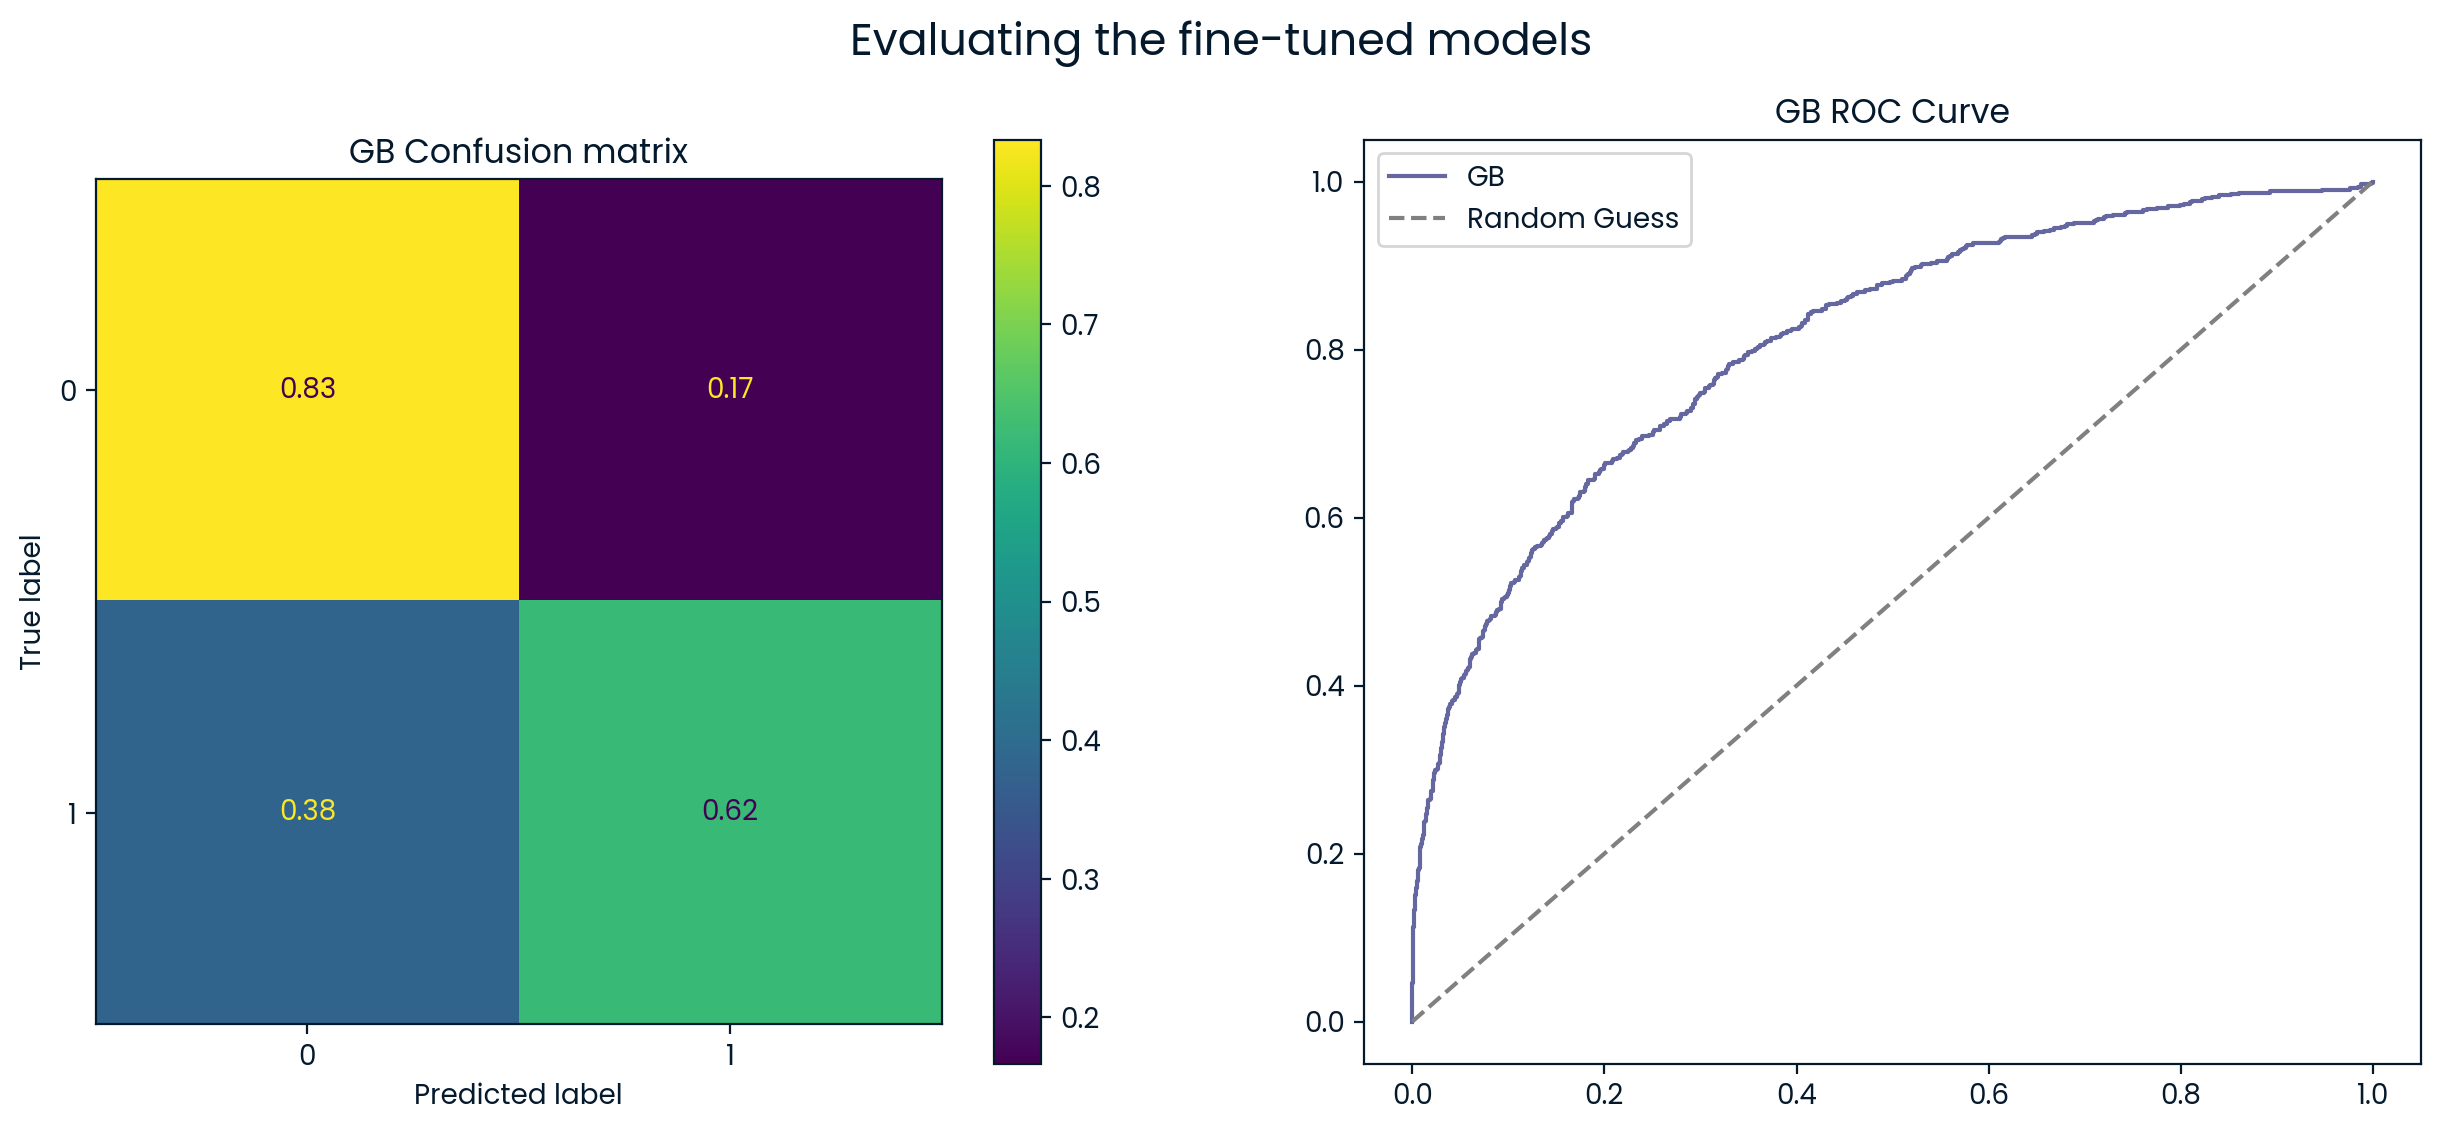

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.79
Precision: 0.49
Recall: 0.62
F1 Score 0.55
AUC: 0.8097985927042863


In [26]:
for name, model in fitted_models.items():
    evaluate_model(X_test, y_test, model, name.upper(), 'Evaluating the fine-tuned models', normalize_matrix='true')


The visual suggests that ***RF* is marginally better with 0.02 higher AUC** than the second one, *Gradient Boosting.* However, the accuracies are almost similar

#### Focusing on Random Forest
Now, let's try to examine hyper-parameters of a Random Forest that produced the best combination:

#### Best Hyperparams

In [27]:
best_params = fitted_models['rf'].best_params_
print(best_params)

{'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_leaf_nodes': 13, 'randomforestclassifier__max_depth': 3}


#### The best model 

In [28]:
best_model = fitted_models['rf'].best_estimator_
print(best_model)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=3, max_leaf_nodes=13,
                                        min_samples_leaf=3, min_samples_split=4,
                                        n_estimators=300, random_state=42))])


## Conclusion
Trained Random Forest classifier on training subset with parameters of max_depth=3, max_leaf_nodes=13, min_samples_leaf=3, min_samples_split=4 and n_estimators=300. The average precision, recall, and f1-scores on validation subsets were 0.48, 0.68, and 0.56, respectively. The area under ROC (AUC) was 0.83.

The Random Forest model demonstrates moderate performance across various evaluation metrics. While the accuracy is decent, indicating overall correctness, there's room for improvement in precision and recall.